# Microsoft malware classification
_Klasifikacija zlonamjernog softvera_

PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK<br>
Projektni prijedlog iz kolegija Strojno učenje <br>
__Travanj 2020.__ <br>

_Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita_

<br>

Jedna od najfinanciranijih i bitnijih IT industrija današnjice zasigurno je ona koja se bavi _malwareima_. Kako se većina zlonamjernog softvera kreira konstantnim (_malicioznim_) mjenjanjem već postojećih _malwarea_, dolazi na važnost njihovo klasificiranje. 

Ideja za projekt dolazi sa [Kaggle natječaja](https://www.kaggle.com/c/malware-classification/overview) - _Microsoft malware classification_.<br>

U ovoj _Jupiter_ bilježnici prikazati ćemo podatke koje je omogućio natječaj. Orginalni podaci veličine su oko pola TB te su podjeljeni u podatke za treniranje i testiranje. Podaci za treniranje algoritma za klasifikaciju imaju specificiranu klasu familije kojoj pripada svaki od _malwarea_. Moguće su sljedeće familije:
    1. Ramnit
    2. Lollipop
    3. Kelihos_ver3
    4. Vundo
    5. Simba
    6. Tracur
    7. Kelihos_ver1
    8. Obfuscator.ACY
    9. Gatak


In [1]:
# rječnik za pamćenje imena klasa malwarea
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

Potrebno je, za svaki _malware_ identificiran jedinstvenim _hash_ kodom iz podataka za testiranje, odrediti kojoj od navedenih klasa pripada. <br> 

Podaci za svaki _malware_ sastoje se od dvije datoteke:
 - __.bytes__ koja sadrži heksadecimalnu reprezentaciju binarnog sadržaja _malwarea_
 - __.asm__ koja sadrži metapodatke izvučene iz binarnih podatataka (npr. korištene funkcije i stringovi u asemblerskom kodu)
<br> <br>


Primjer dvije linije iz jedne __.bytes__ datoteke:

<code>00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08
00401010 BB 42 00 8B C6 5E C2 04 00 CC CC CC CC CC CC CC</code>

Prvi broj, npr <code> 00401000 </code> označava početak adrese desno napisane heksadecimalne reprezentacije binarnog koda u memoriji. Ostale, desne, heksadecimalne vrijednosti predstavljaju važne informacije o samom _malwareu_, npr. instrukcije u kodu. To se može vidjeti i u primjeru nekoliko linija iz jedne __.asm__ datoteke:

<code>.text:00401016						       ; ---------------------------------------------------------------------------
.text:00401019 CC CC CC	CC CC CC CC					       align 10h
.text:00401020 C7 01 08	BB 42 00					       mov     dword ptr [ecx],	offset off_42BB08
.text:00401026 E9 26 1C	00 00						       jmp     sub_402C51
.text:00401026						       ; ---------------------------------------------------------------------------</code>

<br>
<br>

In [77]:
# potrebni paketi
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk

In [156]:
# funkcija za crtanje histograma pri čemu se uzimaju u obzir kvantili pri odabiru binsa

# ulazne varijable:
#                    data - dataframe varijabla sa značajkama
#                    classes - varijabla koja ima informacije o početnom i krajnjem retku neke klase malwarea
#                    features - polje sa točno određenim stupcim koji predstavljaju značajke za koje ćemo nacrtati histogram
#                    sections - na koliko dijelova ćemo podijeliti histogram
#                    no_rows - broj redaka histograma
#                    no_cols - broj stupaca histograma
#                    fi_x, fig_y - dimenzije grafa histograma

def draw_histograms_rows_quantile( data, classes, features, sections, no_rows, no_cols, fig_x, fig_y, i_want_whole_range ):
    fig, axes = plt.subplots(no_rows, no_cols, figsize=(fig_x, fig_y))
    ax = axes.ravel() 

    for i in range(len(features)):
        col = features[i]
        
        noNaNdata = data.iloc[:,col].to_numpy()[~np.isnan(data.iloc[:,col].to_numpy())]
        q20 = np.quantile(noNaNdata, 0.25)
        q80 = np.quantile(noNaNdata, 0.75)
        if q20 == q80 or i_want_whole_range[i] :
            _, bins = np.histogram(noNaNdata, bins=sections)
        else:
            bins = [ q20 + j * ( (q80-q20)/sections ) for j in range(sections)]
        
        ax[i].hist(data.iloc[classes[1][0]:classes[1][1], col].to_numpy(), 
                   bins=bins, color='red', alpha=.5, label=malware_dict[1])

        ax[i].hist(data.iloc[classes[2][0]:classes[2][1], col].to_numpy(), 
                   bins=bins, color='blue', alpha=.5, label=malware_dict[2])

        ax[i].hist(data.iloc[classes[3][0]:classes[3][1], col].to_numpy(), 
                   bins=bins, color='green', alpha=.5, label=malware_dict[3])

        ax[i].hist(data.iloc[classes[4][0]:classes[4][1], col].to_numpy(), 
                   bins=bins, color='yellow', alpha=.5, label=malware_dict[4])

        ax[i].hist(data.iloc[classes[5][0]:classes[5][1], col].to_numpy(), 
                   bins=bins, color='orange', alpha=.5, label=malware_dict[5])

        ax[i].hist(data.iloc[classes[6][0]:classes[6][1], col].to_numpy(), 
                   bins=bins, color='pink', alpha=.5, label=malware_dict[6])

        ax[i].hist(data.iloc[classes[7][0]:classes[7][1], col].to_numpy(), 
                   bins=bins, color='grey', alpha=.5, label=malware_dict[7])

        ax[i].hist(data.iloc[classes[8][0]:classes[8][1], col].to_numpy(), 
                   bins=bins, color='magenta', alpha=.5, label=malware_dict[8])   

        ax[i].hist(data.iloc[classes[9][0]:classes[9][1], col].to_numpy(), 
                   bins=bins, color='purple', alpha=.5, label=malware_dict[9]) 
        
        ax[i].set_title(data.columns.values[col])
        ax[i].set_yticks(()) # remove ticks on y-axis
        ax[i].legend(loc='upper right')
        fig.tight_layout()

## Analiza značajki 
_Features analysis_

Kako orginalni podaci nemaju točno određene _feature_ koje bi upotrijebili u algoritmu za klasificiranje, rudarili smo podatke po uzoru na članak: [_Novel Feature Extraction, Selection and Fusion for Effective Malware Family Classification_](https://www.researchgate.net/publication/283986464_Novel_Feature_Extraction_Selection_and_Fusion_for_Effective_Malware_Family_Classification) korišteći njihov gotovi [kod](https://github.com/ManSoSec/Microsoft-Malware-Challenge) koji su objavili, uz male promjene. Kratka analiza i pregled koda može se vidjeti u _feature extraction.ipynb_. 


In [4]:
# učitavanje svih značajki
features = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_train.csv")
features.head()

,Id,Class,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,...,dd6,dd4_all,dd5_all,dd6_all,db3_idata,db3_NdNt,dd4_NdNt,dd5_NdNt,dd6_NdNt,db3_all_zero
0,01kcPWA9K2BOxQeS5Rju,1,21091,1213,726,817,1257,625,550,523,...,0.0,0.000000,0.002351,0.000000,0.0,0.0,0.000000,0.003822,0.000000,0.370787
1,04EjIdbPV5e1XroFOpiN,1,40030,1980,1226,1193,1971,1096,961,755,...,9.0,0.001068,0.000542,0.000139,0.0,0.0,0.001561,0.000792,0.000204,0.396007
2,05EeG39MTRrI6VY21DPd,1,19419,955,693,656,832,463,370,510,...,0.0,0.000252,0.000503,0.000000,0.0,0.0,0.000442,0.000884,0.000000,0.376826
3,05rJTUWYAKNegBk2wE8X,1,79568,6445,3143,2517,4982,1824,2125,2964,...,106.0,0.000337,0.000471,0.000458,0.0,0.0,0.000619,0.000876,0.000852,0.435593
4,0AnoOZDNbPXIr2MRBSCJ,1,25791,1202,569,750,948,456,405,517,...,0.0,0.000238,0.000178,0.000000,0.0,0.0,0.000496,0.000372,0.000000,0.474631


In [5]:
# spremanje vrijednosti početnog i krajnjeg retka pojedine klase
classes_begining_and_end_in_features = { }
last = 0

for i in range(1,10):
    classes_begining_and_end_in_features[i] = [last, len(features.loc[features.Class == i])]
    last = len(features.loc[features.Class == i])

print(classes_begining_and_end_in_features)

{1: [0, 1541], 2: [1541, 2477], 3: [2477, 2942], 4: [2942, 475], 5: [475, 42], 6: [42, 751], 7: [751, 398], 8: [398, 1228], 9: [1228, 1013]}


###  _featuri_ dobivene iz __.bytes__ datoteke

#### 1 - gram 
_1G_

In [6]:
# ONE GRAM značajke
# one_gram = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/byte_oneg.csv")
one_gram_features = features.iloc[:,2:258]
one_gram_features.head()

,byte_1G_00,byte_1G_01,byte_1G_02,byte_1G_03,byte_1G_04,byte_1G_05,byte_1G_06,byte_1G_07,byte_1G_08,byte_1G_09,...,byte_1G_f6,byte_1G_f7,byte_1G_f8,byte_1G_f9,byte_1G_fa,byte_1G_fb,byte_1G_fc,byte_1G_fd,byte_1G_fe,byte_1G_ff
0,21091,1213,726,817,1257,625,550,523,1078,473,...,446,478,873,485,462,516,1133,471,761,7998
1,40030,1980,1226,1193,1971,1096,961,755,2406,550,...,585,377,806,479,357,394,1114,507,1080,10826
2,19419,955,693,656,832,463,370,510,836,449,...,348,434,463,354,472,393,384,303,390,2104
3,79568,6445,3143,2517,4982,1824,2125,2964,8301,1530,...,2626,3753,4012,1511,1604,2407,5196,4614,4448,47484
4,25791,1202,569,750,948,456,405,517,754,494,...,385,402,500,316,297,343,452,283,401,4532


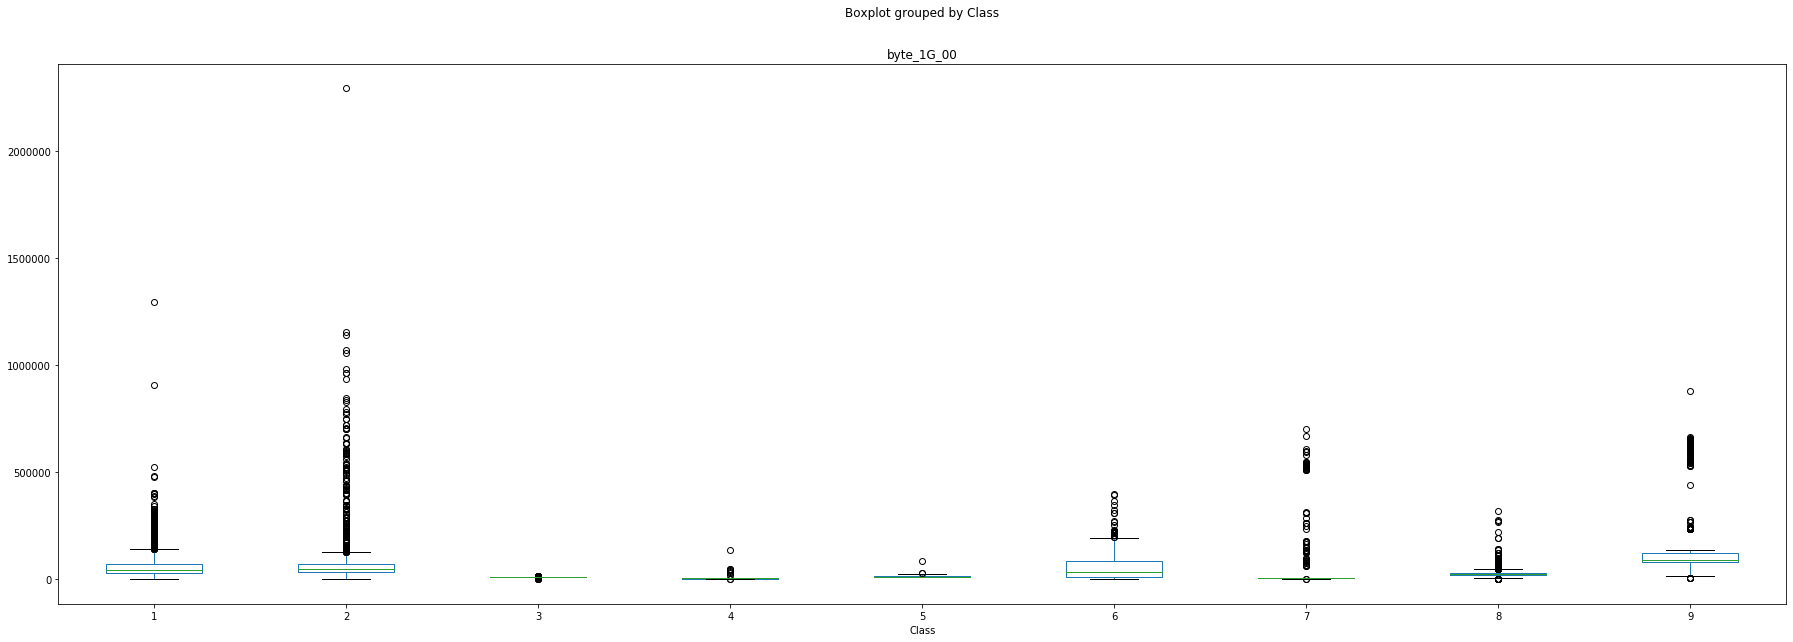

In [167]:
features.boxplot(column=[one_gram_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

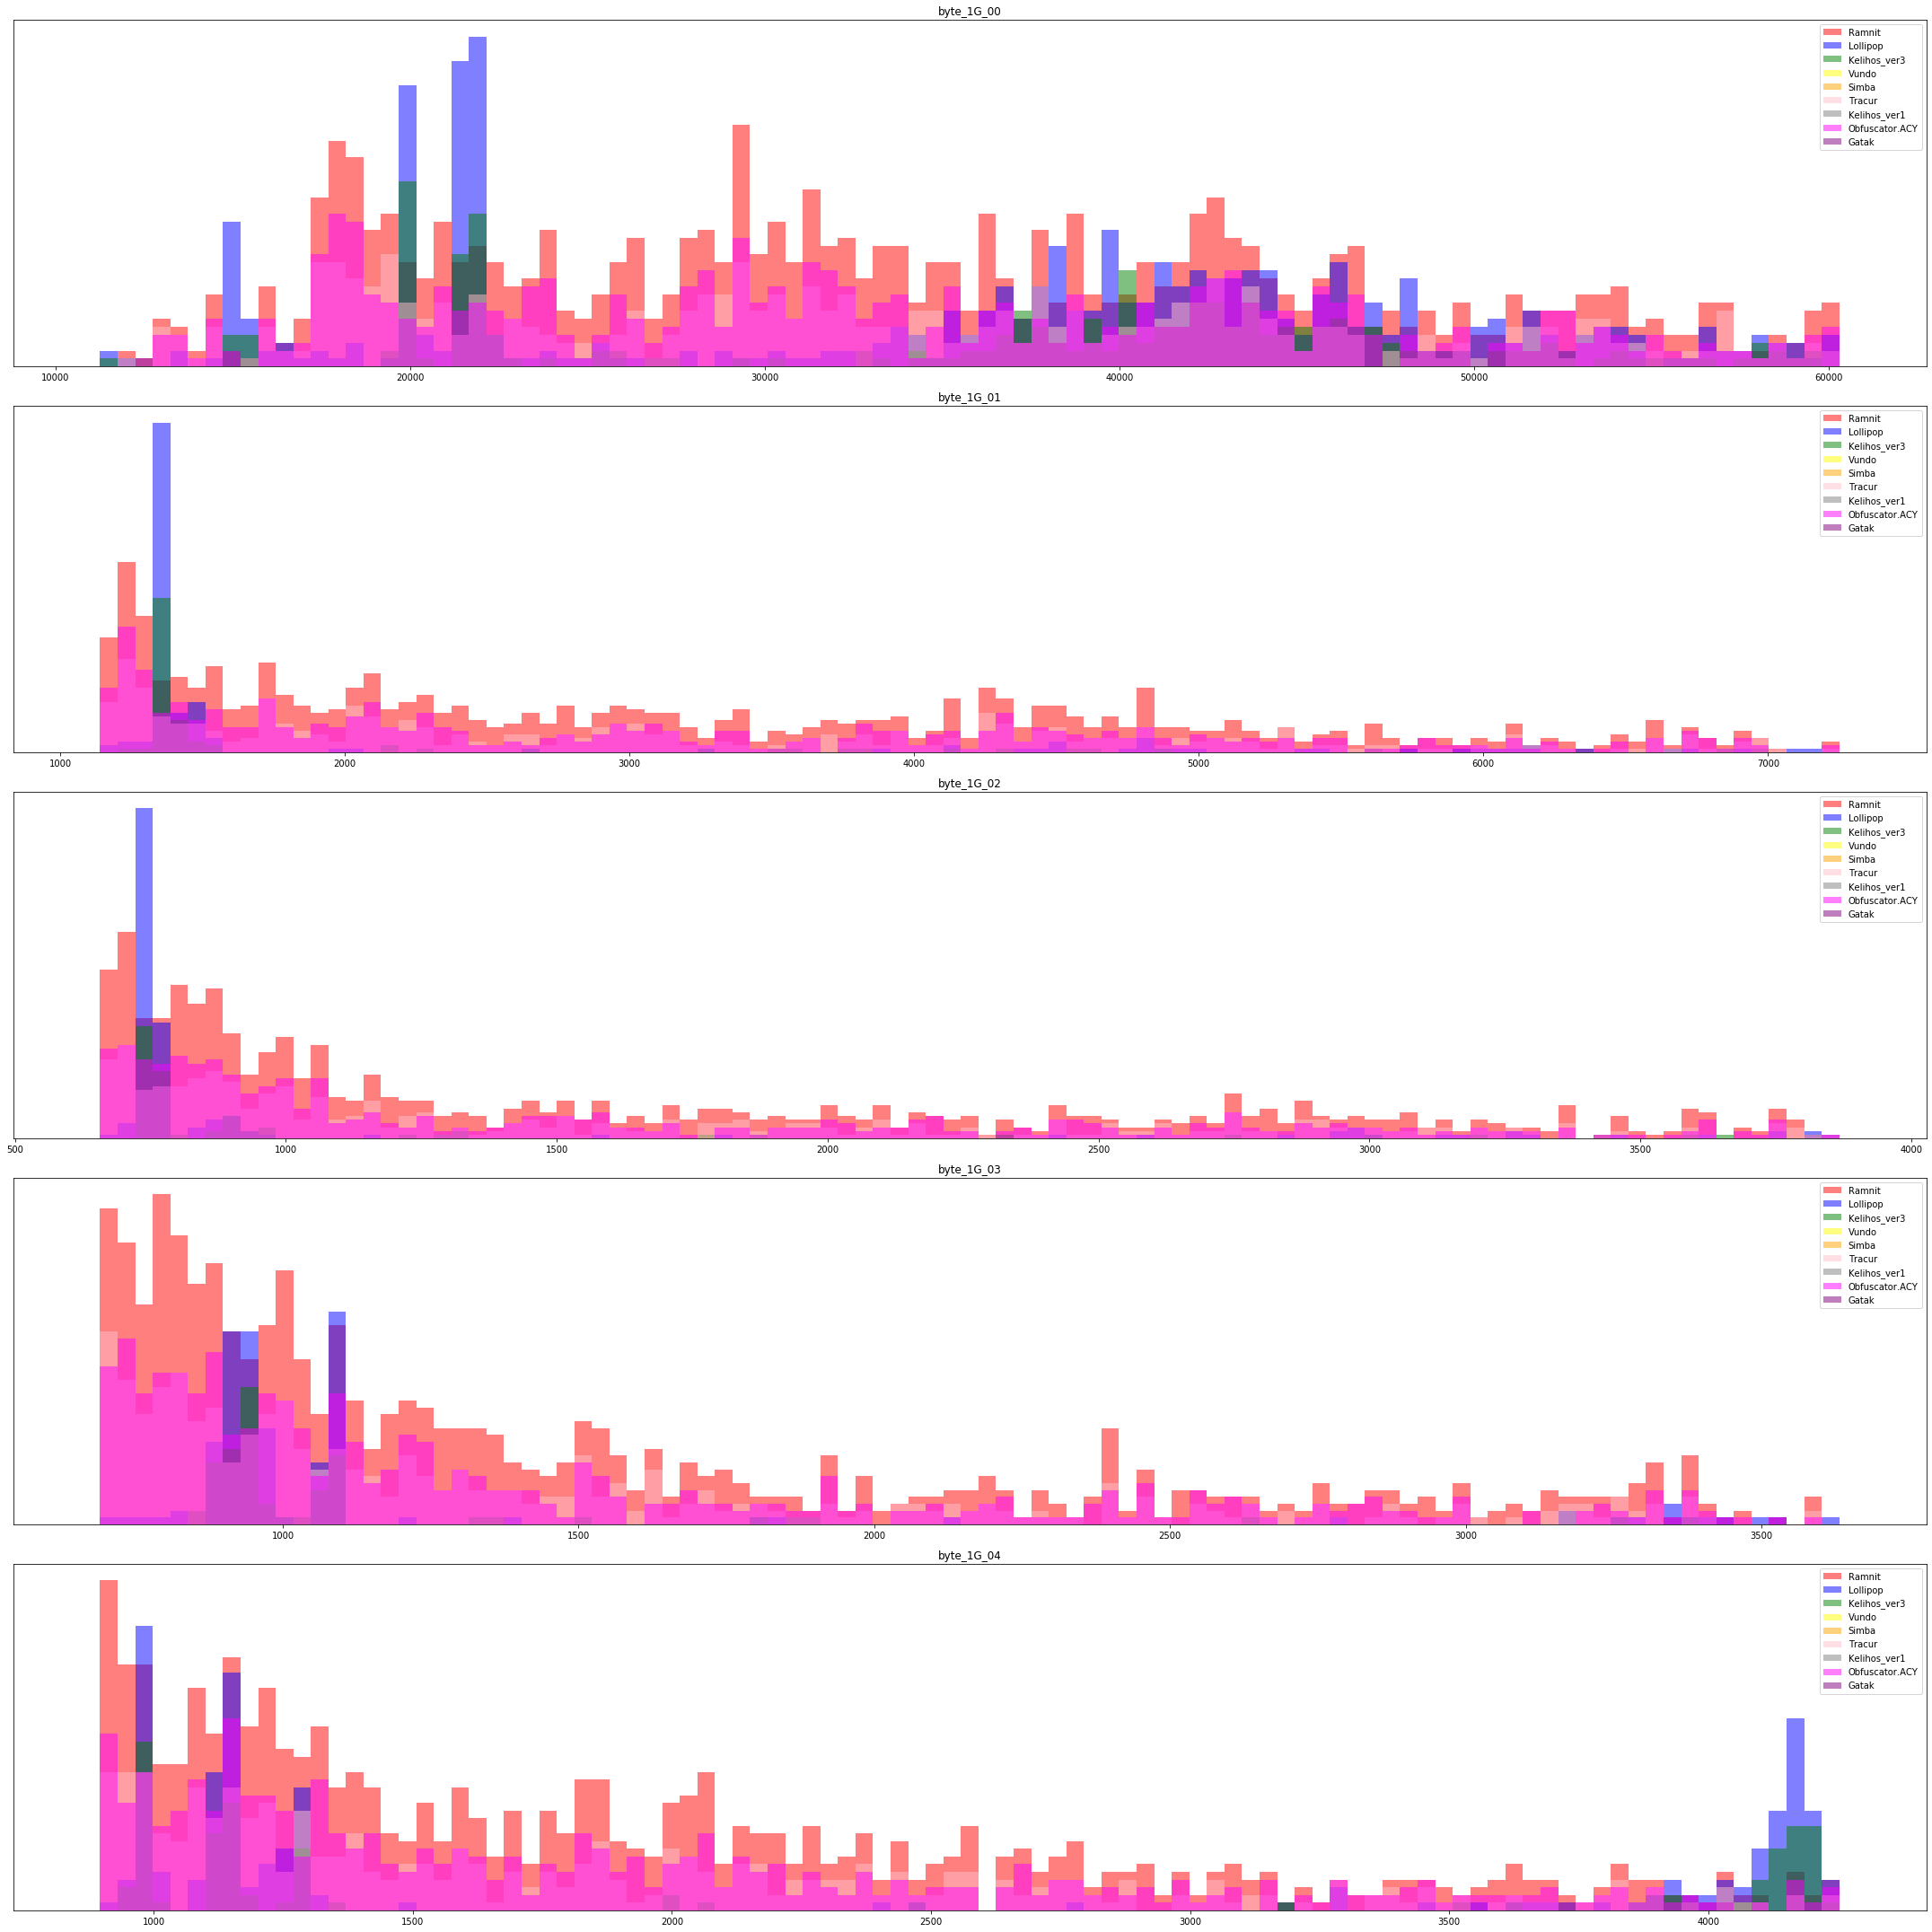

In [115]:
draw_histograms_rows_quantile( data = one_gram_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4], 
                              sections = 100, 
                              no_rows = 5, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*5 )

#### (byte) metadata 
_MDB_

In [24]:
# METADATA značajke iz bytes datoteki
metadata_bytes_features = features.iloc[:,258:260]
metadata_bytes_features.head()

,byte_filesize,byte_offset
0,244445,268439552
1,268254,1307774976
2,169207,268439552
3,771461,2112880640
4,167821,268439552


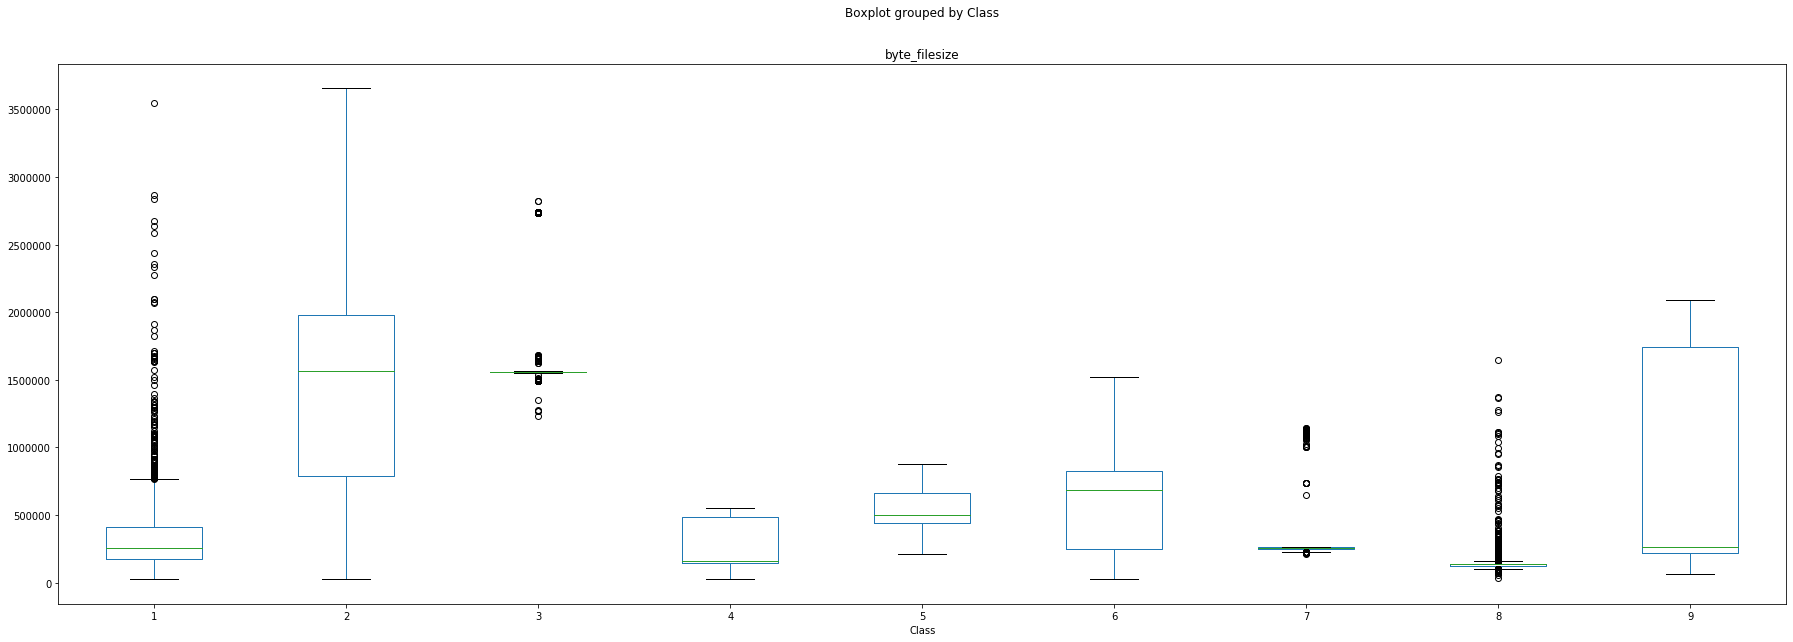

In [166]:
features.boxplot(column=[metadata_bytes_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

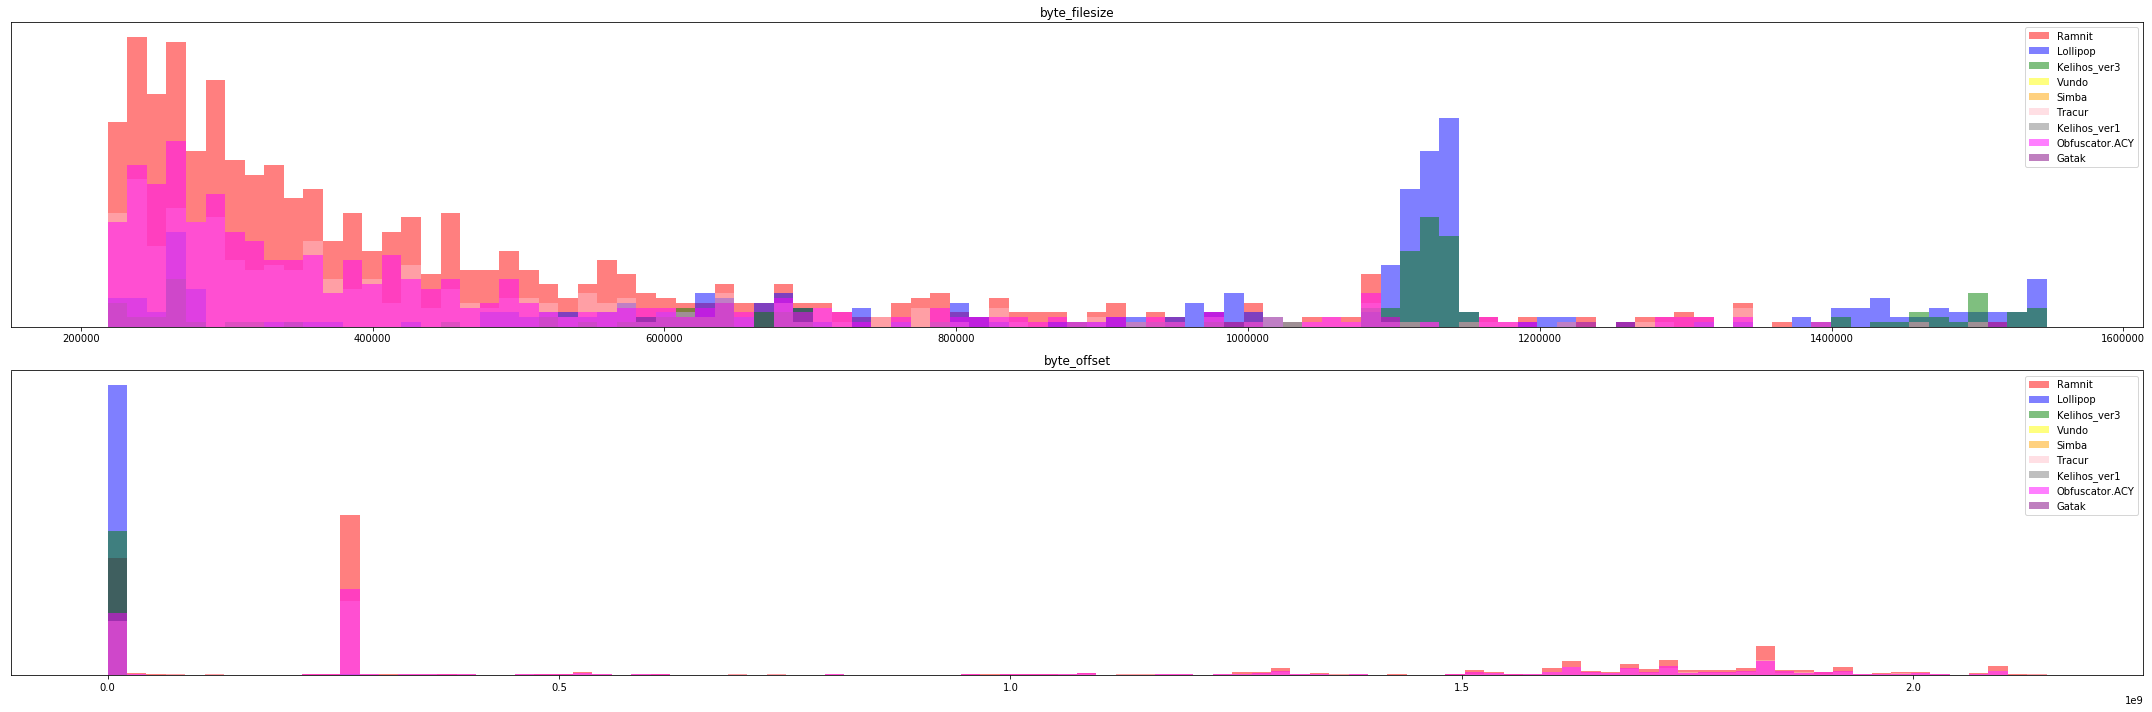

In [116]:
draw_histograms_rows_quantile( data = metadata_bytes_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1], 
                              sections = 100, 
                              no_rows = 2, no_cols = 1, 
                              fig_x = 30, fig_y = 10,
                              i_want_whole_range = [False, True])

#### entropija
_ENT_

In [78]:
# ENTROPY značajke 
entropy_features = features.iloc[:,260:462]
entropy_features.head()

,ent_q_diffs_0,ent_q_diffs_1,ent_q_diffs_2,ent_q_diffs_3,ent_q_diffs_4,ent_q_diffs_5,ent_q_diffs_6,ent_q_diffs_7,ent_q_diffs_8,ent_q_diffs_9,...,ent_p_diffs_10,ent_p_diffs_11,ent_p_diffs_12,ent_p_diffs_13,ent_p_diffs_14,ent_p_diffs_15,ent_p_diffs_16,ent_p_diffs_17,ent_p_diffs_18,ent_p_diffs_19
0,0.000000,0.000000,0.007566,0.002348,0.001304,0.015914,0.003913,0.006261,0.004957,0.003652,...,0.023297,0.026589,0.032918,0.205912,0.000591,0.000359,0.000232,0.000230,0.000256,0.000259
1,0.000000,0.000000,0.000000,0.000000,0.001661,0.003738,0.002492,0.005399,0.012874,0.008306,...,0.012580,0.013367,0.014517,0.017450,0.028586,0.205772,0.020981,0.002177,0.002937,0.002568
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011930,0.008772,0.007368,...,0.017624,0.267654,0.037895,0.007731,0.002728,0.001414,0.001426,0.001377,0.001329,0.003496
3,0.042895,0.003679,0.002993,0.004925,0.001247,0.001559,0.001309,0.001683,0.002120,0.003429,...,0.011928,0.010840,0.011953,0.011937,0.012959,0.015994,0.032501,0.183997,0.028849,0.003329
4,0.105760,0.002203,0.002518,0.003462,0.004721,0.011331,0.001889,0.025181,0.027070,0.038401,...,0.014489,0.013735,0.075768,0.224453,0.000551,0.000227,0.000307,0.000312,0.000231,0.000145


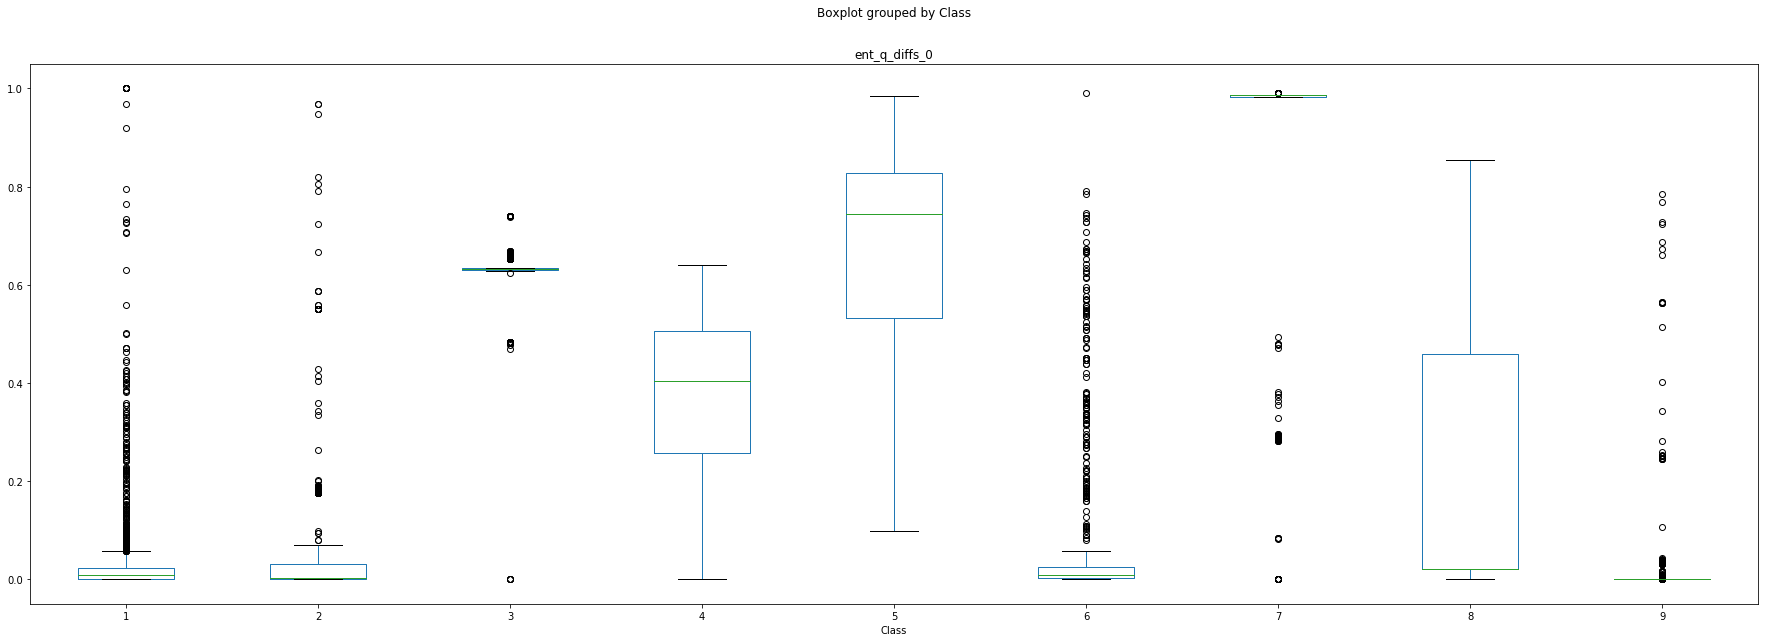

In [82]:
features.boxplot(column=[entropy_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

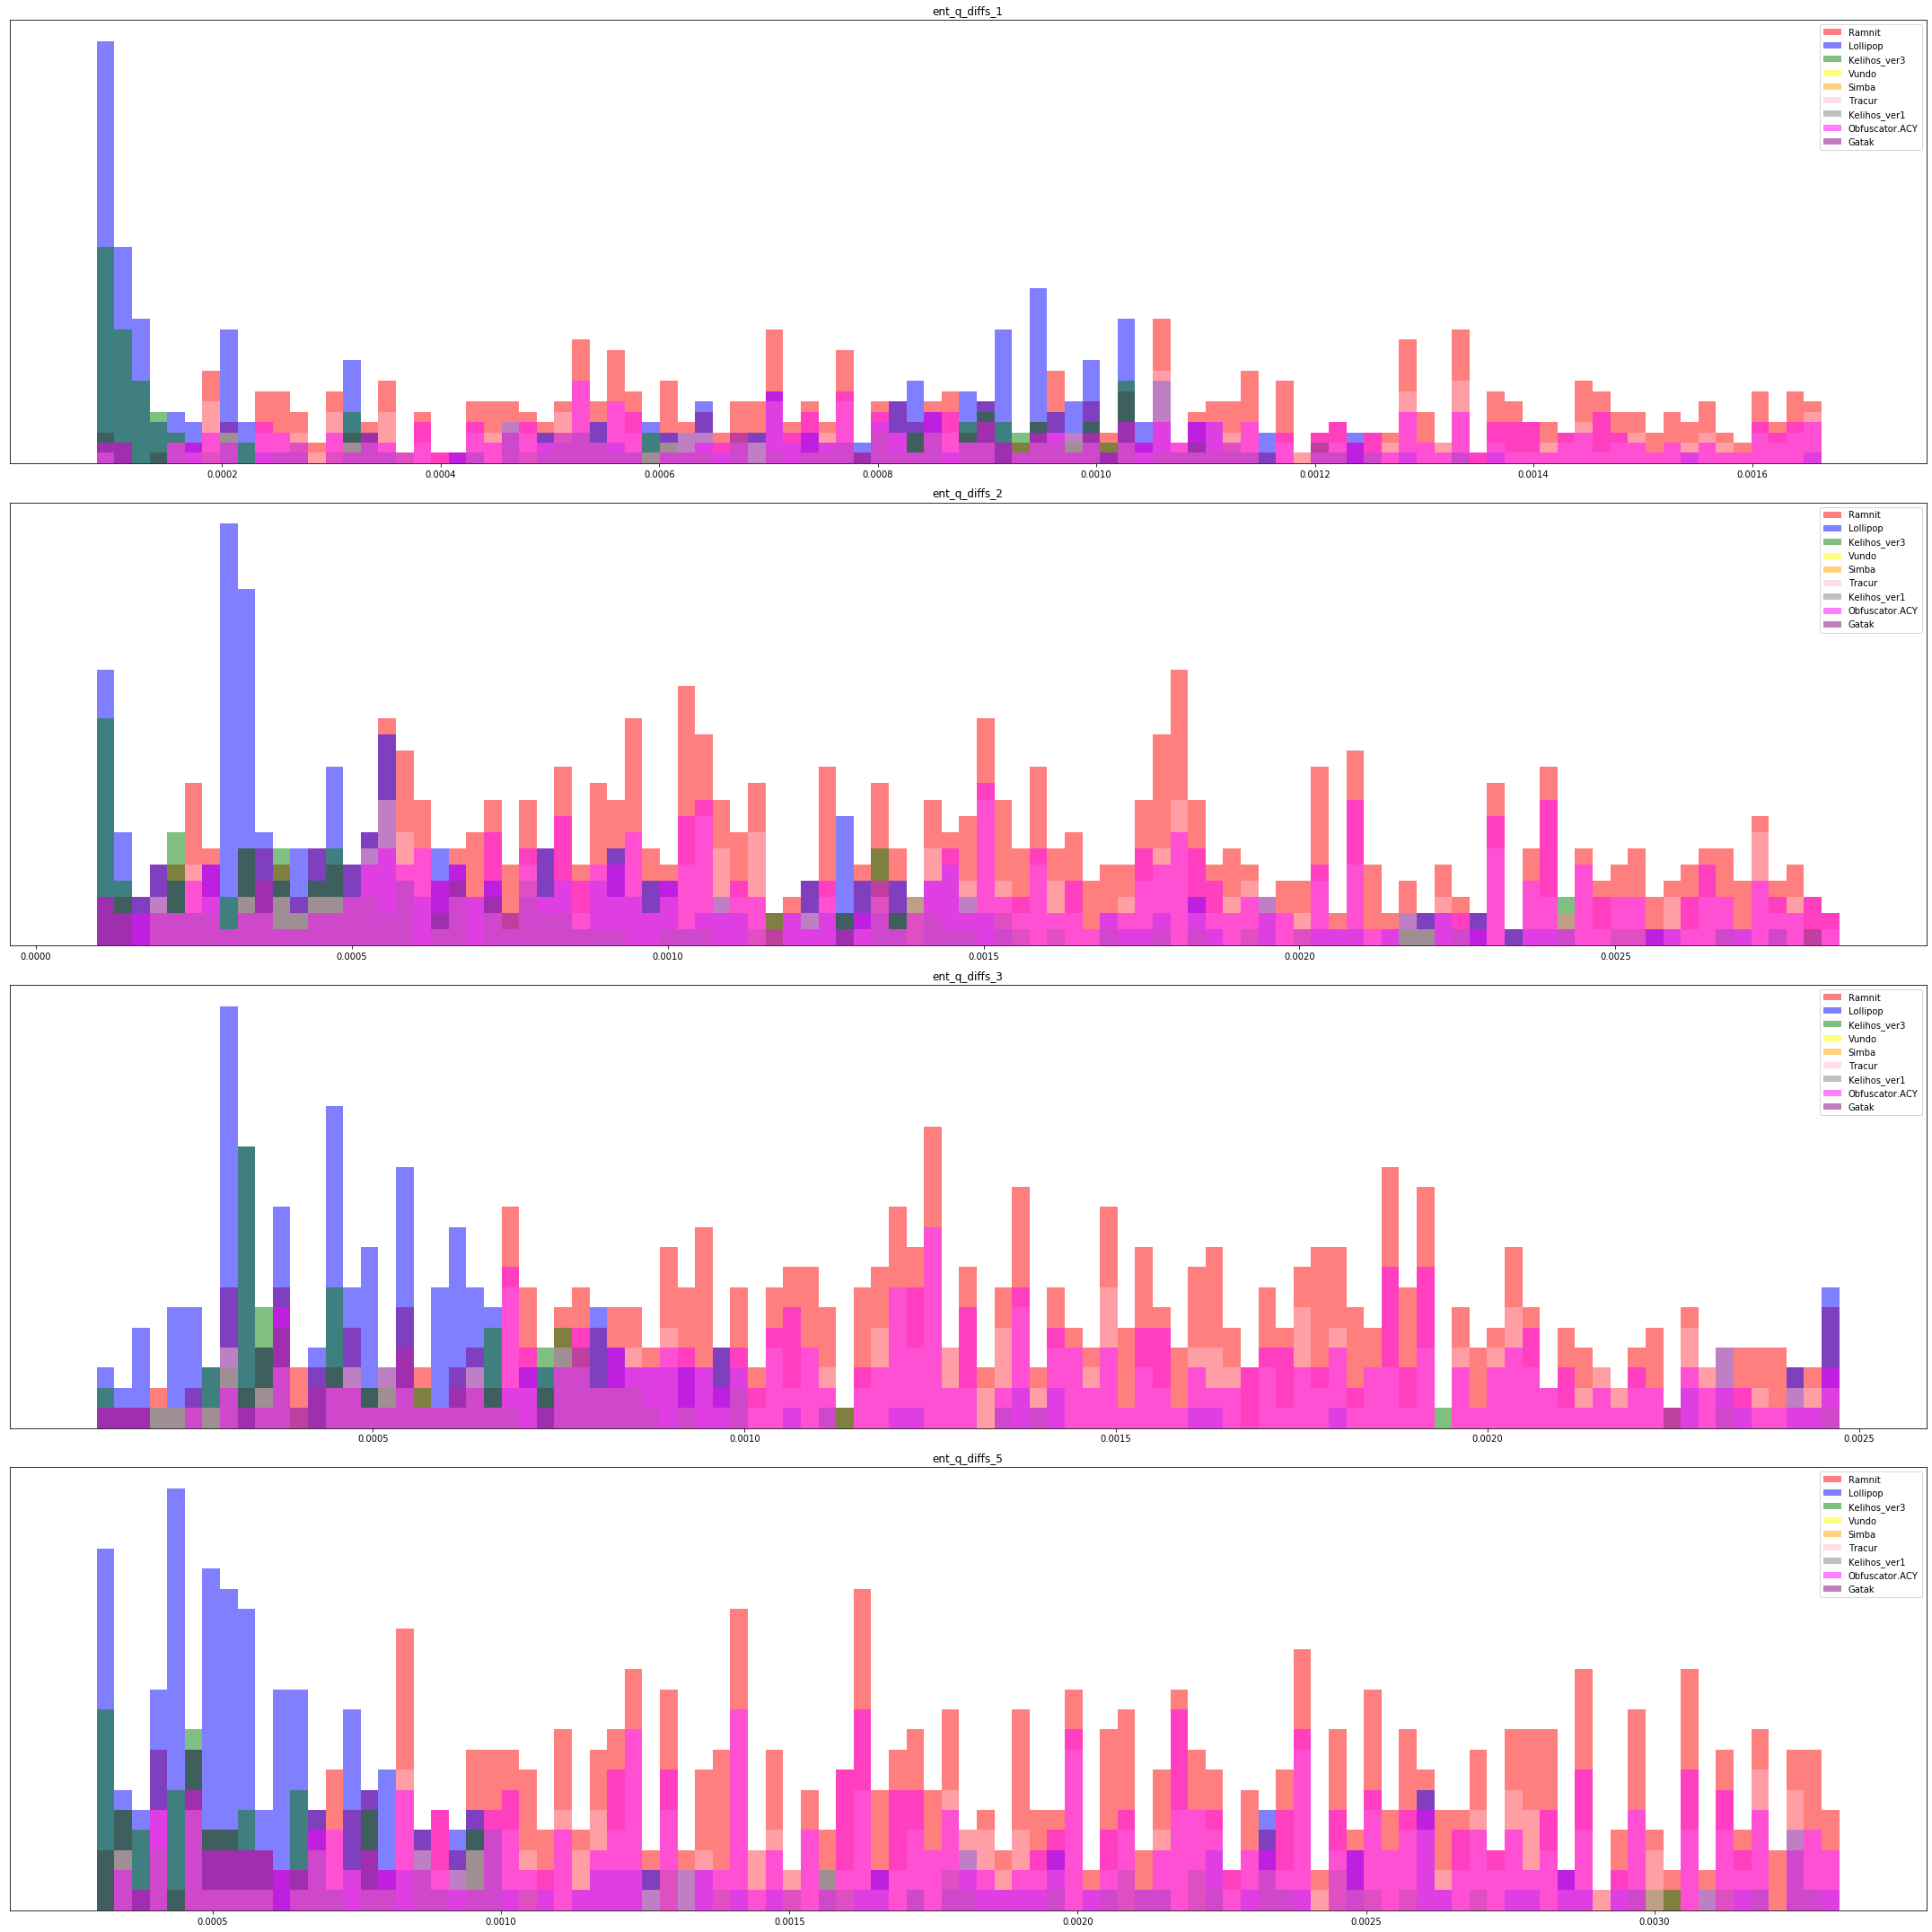

In [117]:
draw_histograms_rows_quantile( data = entropy_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [1,2,3,5], 
                              sections = 100, 
                              no_rows = 4, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*4)

#### slikovna reprezentacija virusa
_IMG_

In [79]:
# IMAGE značajke 
image_features = features.iloc[:,462:514]
image_features.head()

,byte_Img1_0,byte_Img1_1,byte_Img1_2,byte_Img1_3,byte_Img1_4,byte_Img1_5,byte_Img1_6,byte_Img1_7,byte_Img1_8,byte_Img1_9,...,byte_Img1_42,byte_Img1_43,byte_Img1_44,byte_Img1_45,byte_Img1_46,byte_Img1_47,byte_Img1_48,byte_Img1_49,byte_Img1_50,byte_Img1_51
0,0.015560,10424.169276,0.281469,7253.810043,0.156883,212.615694,18591.070896,8.210199,13.388960,0.000084,...,7249.009377,0.124144,212.958541,17659.172940,8.326136,13.572401,0.000053,7.372721,-0.055253,0.733179
1,0.011125,10473.182086,0.271823,7191.372064,0.164023,211.027128,18292.306170,8.230688,12.850389,0.000091,...,7184.466418,0.086442,211.403879,15893.078448,8.487462,13.539992,0.000026,7.537879,-0.041308,0.659622
2,0.018087,9085.748498,0.337131,6853.347321,0.178820,200.000020,18327.640785,8.130132,13.127777,0.000109,...,6849.972073,0.127715,200.335102,16933.666122,8.316946,13.567806,0.000055,7.320932,-0.069984,0.791311
3,0.011778,9011.326305,0.365131,7096.999995,0.168553,211.663779,19376.673675,8.164637,12.428762,0.000091,...,7093.548415,0.106594,211.884756,16965.997099,8.429733,13.363649,0.000039,7.417455,-0.046947,0.688479
4,0.079121,8022.383513,0.453116,7334.630795,0.322679,168.166512,21316.139666,7.098649,11.328309,0.000376,...,7334.530615,0.264222,168.394193,19276.023700,7.346720,11.746061,0.000254,6.543933,-0.095994,0.833108


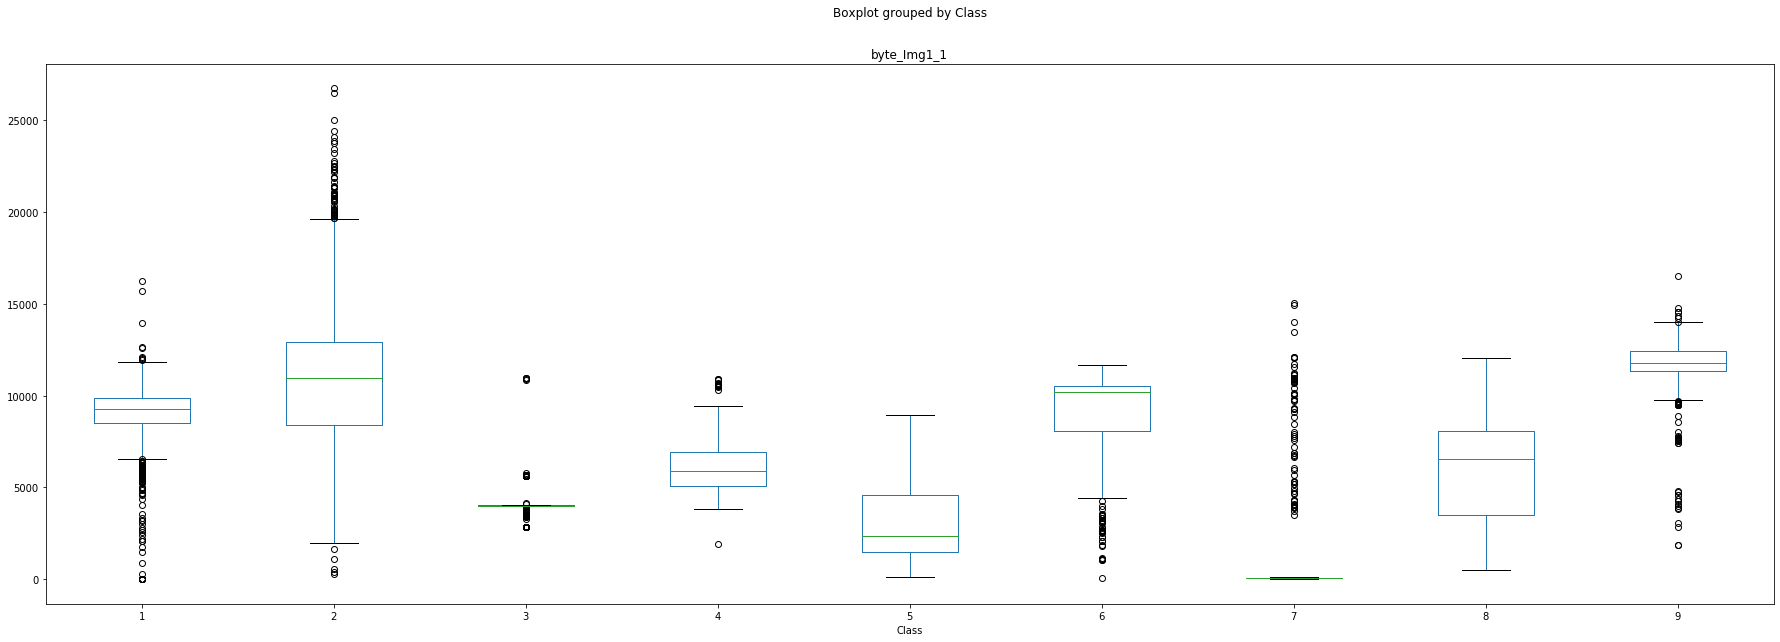

In [165]:
features.boxplot(column=[image_features.columns.values[1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

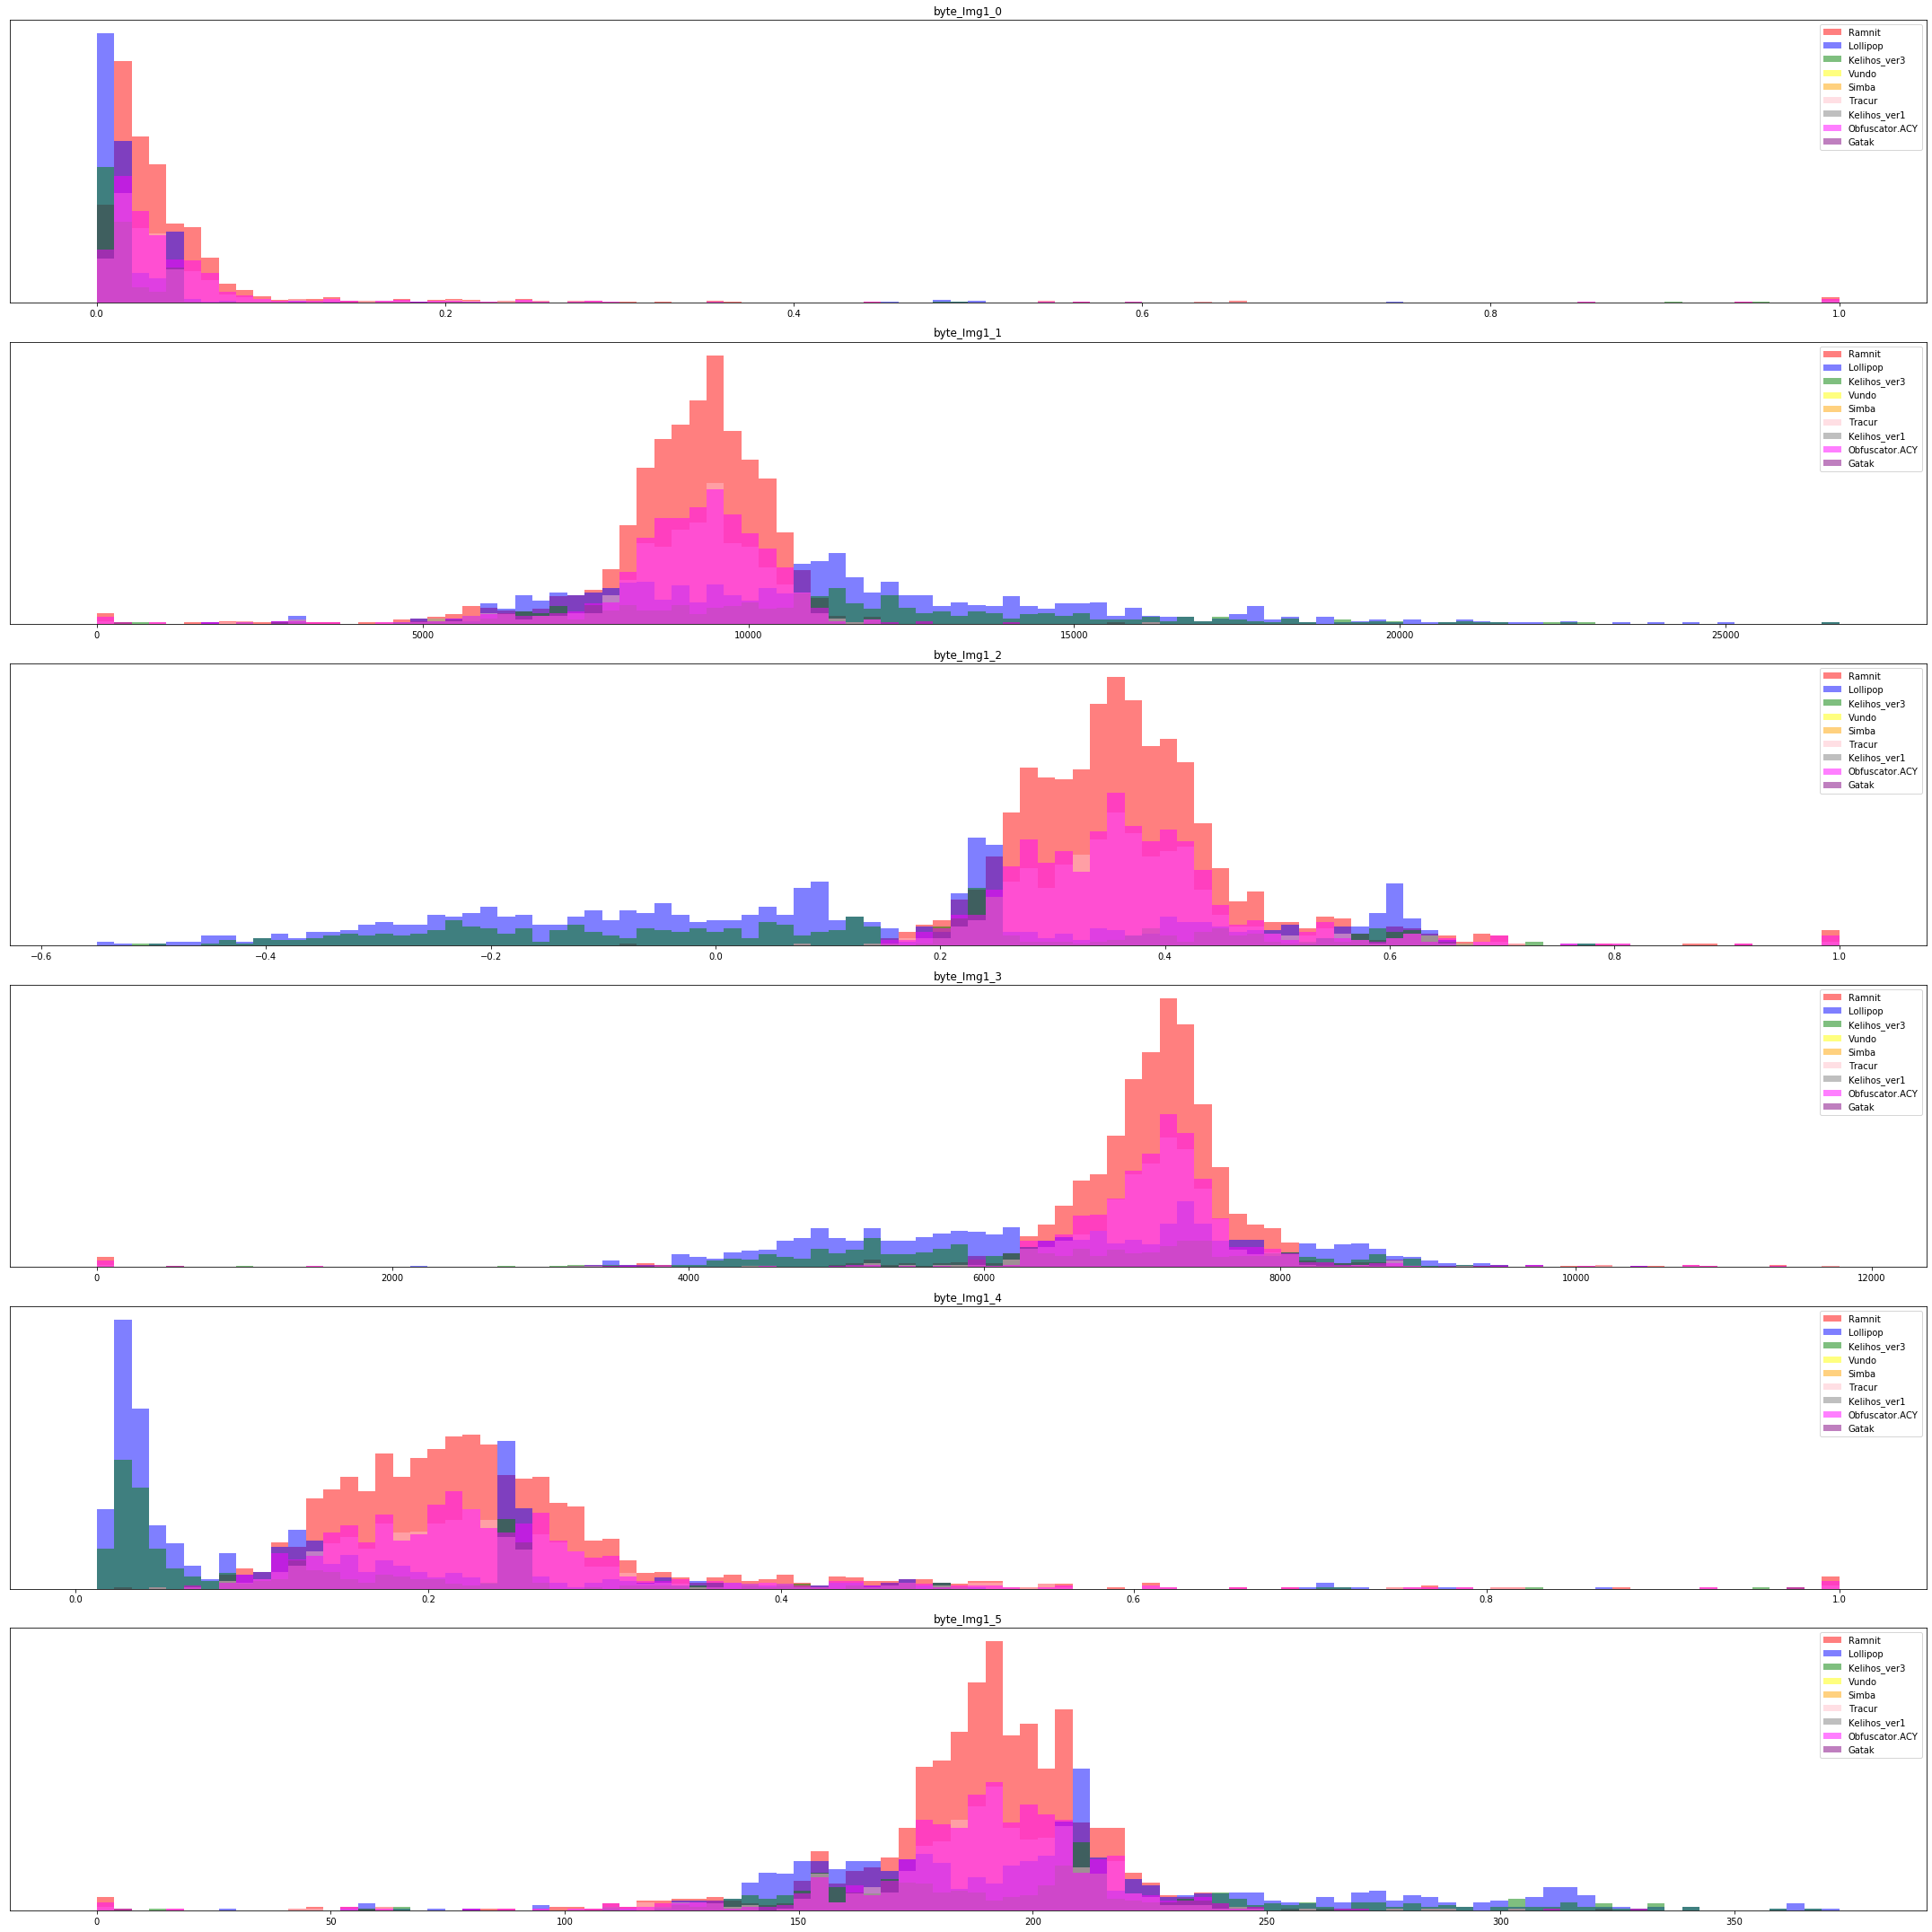

In [118]:
draw_histograms_rows_quantile( data = image_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5], 
                              sections = 100, 
                              no_rows = 6, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [True]*6)

#### duljina stringova
_STR_

In [80]:
# STRING LENGTH značajke 
string_length_features = features.iloc[:,514:630]
string_length_features.head()

,string_len_counts_1,string_len_counts_2,string_len_counts_3,string_len_counts_4,string_len_counts_5,string_len_counts_6,string_len_counts_7,string_len_counts_8,string_len_counts_9,string_len_counts_10,...,string_len_counts_250_400,string_len_counts_400_600,string_len_counts_600_900,string_len_counts_900_1300,string_len_counts_1300_2000,string_len_counts_2000_3000,string_len_counts_3000_6000,string_len_counts_6000_15000,string_total_len,string_ratio
0,3780,1026,513,173,175,79,28,20,6,10,...,0,0,0,0,0,0,0,1,9664,0.049154
1,7252,961,102,56,16,25,12,13,9,8,...,0,0,0,0,1,0,0,1,11961,0.048669
2,2854,661,488,21,19,5,14,3,7,5,...,0,0,0,0,0,0,0,1,15716,0.106581
3,18932,942,251,131,79,46,46,54,61,54,...,0,0,0,0,0,0,0,1,41668,0.051639
4,1283,1082,78,41,24,18,17,8,9,15,...,0,0,0,0,0,0,0,1,5252,0.032056


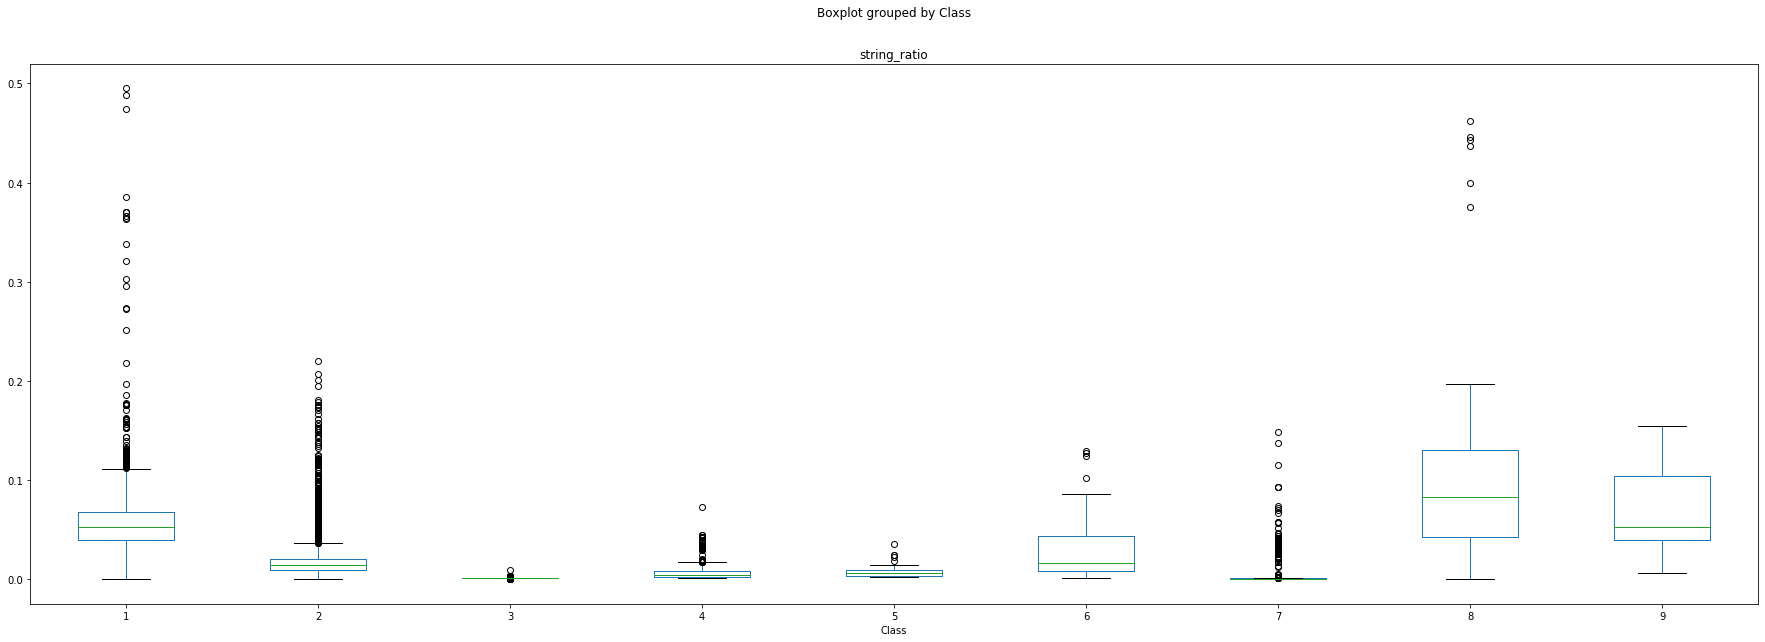

In [171]:
features.boxplot(column=[string_length_features.columns.values[-1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

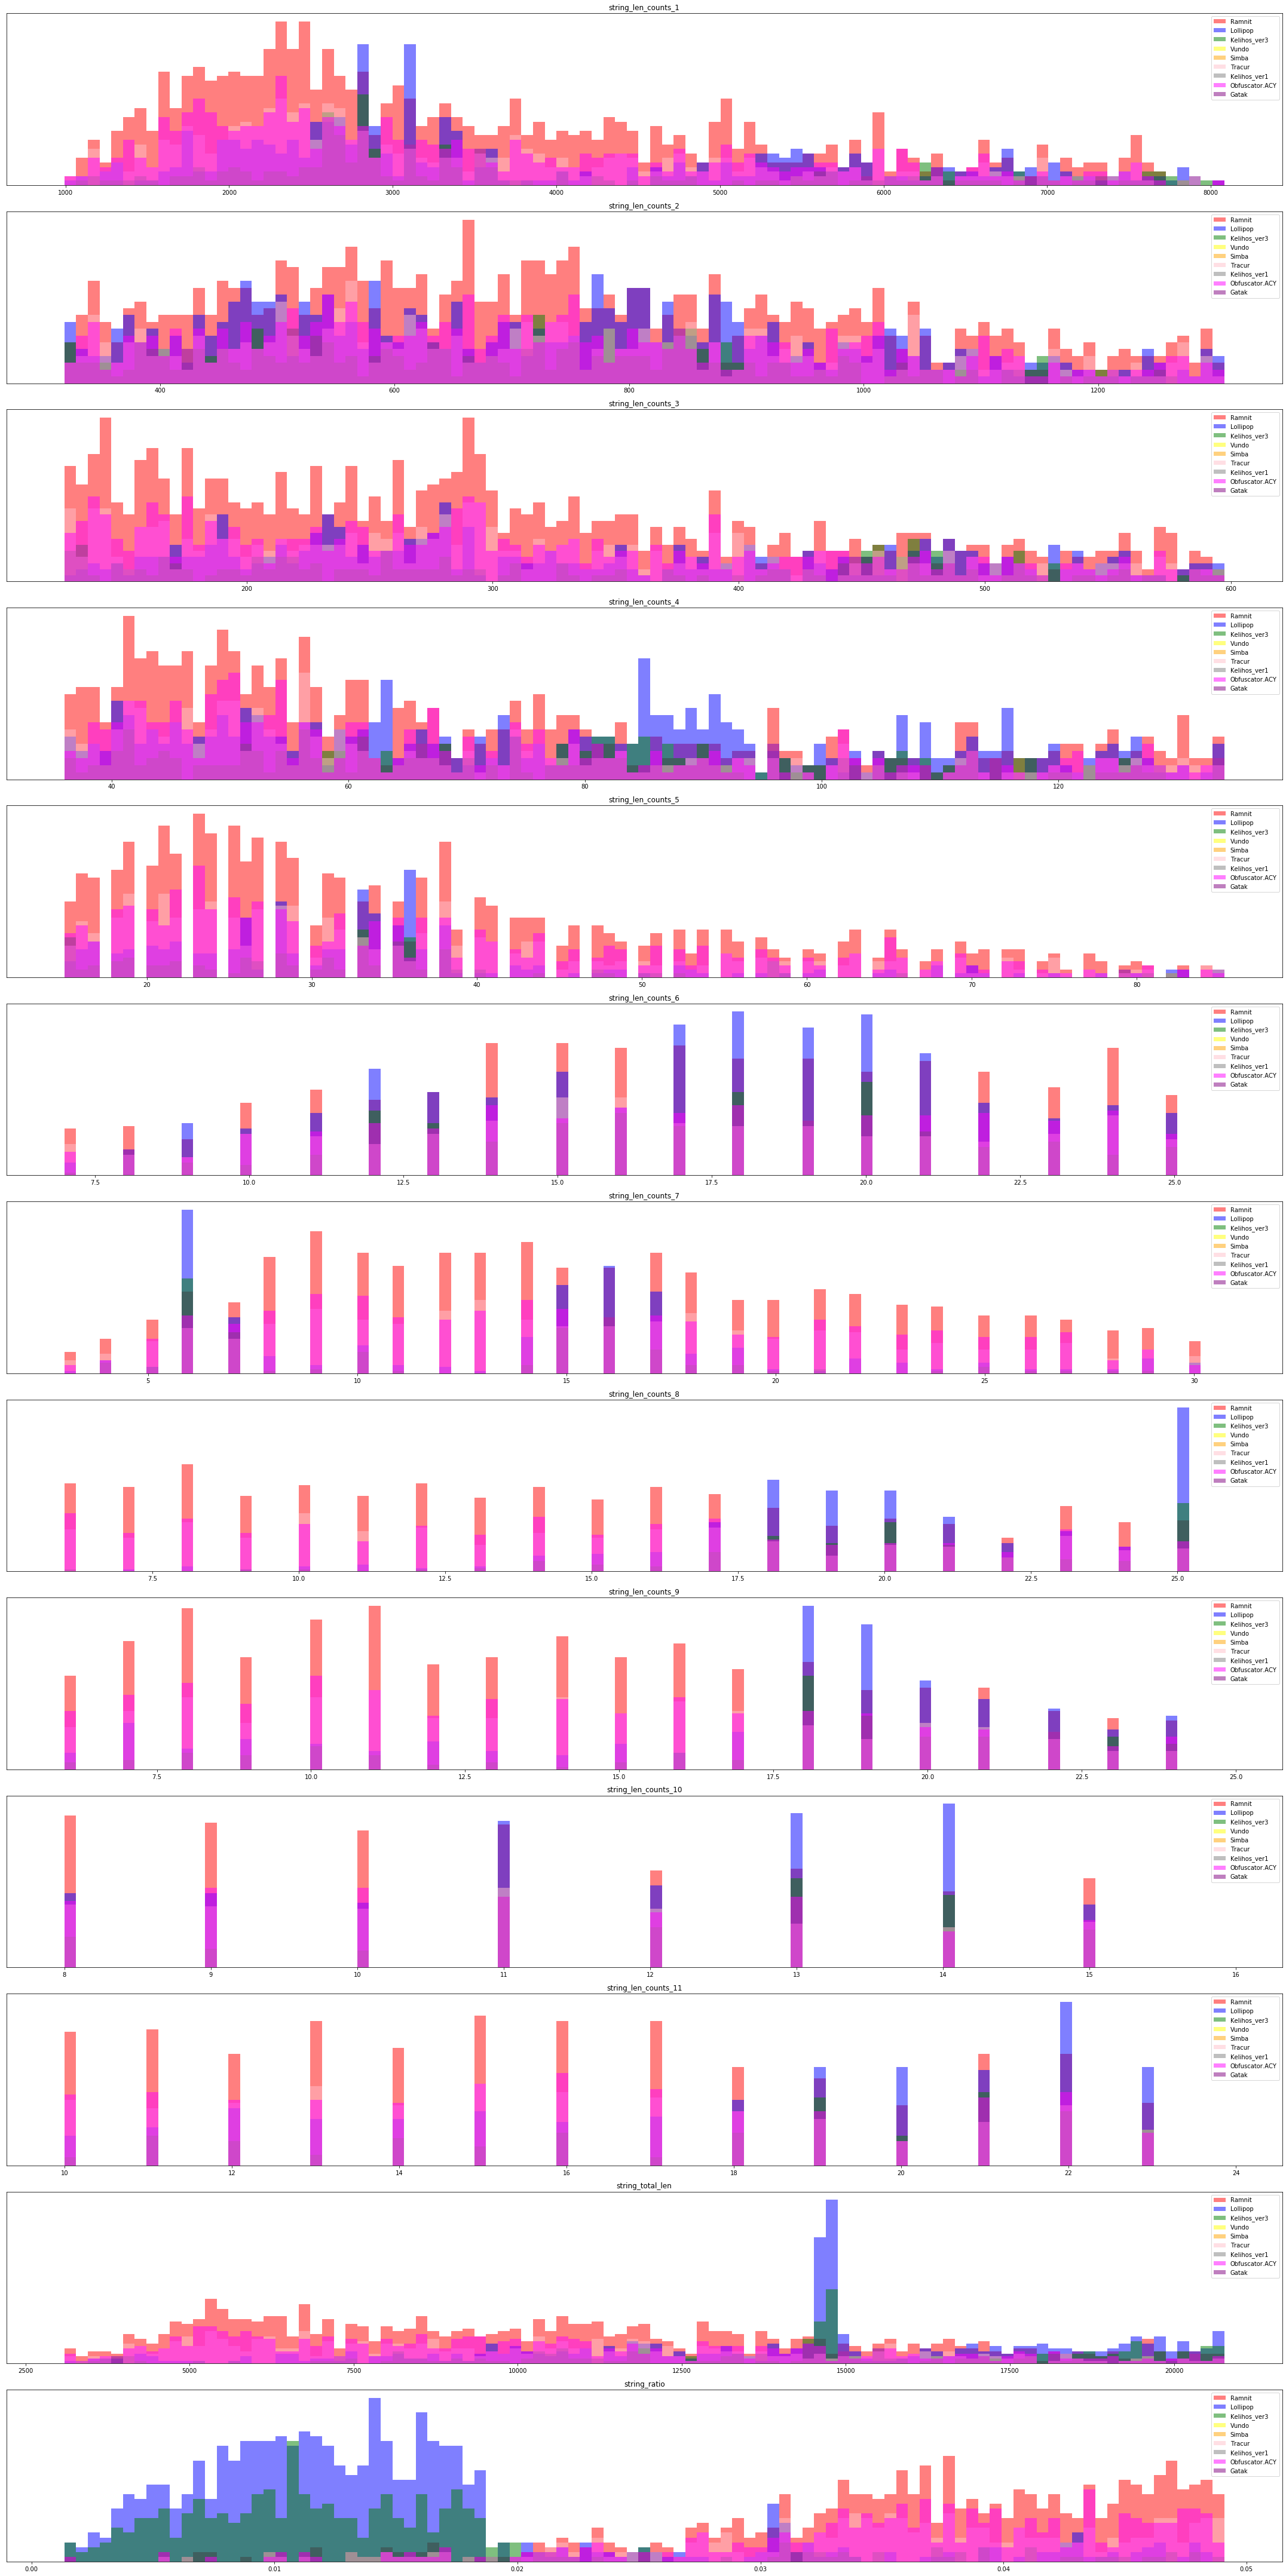

In [174]:
draw_histograms_rows_quantile( data = string_length_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5,6,7,8,9,10,-2,-1], 
                              sections = 100, 
                              no_rows = 13, no_cols = 1, 
                              fig_x = 30, fig_y = 60,
                              i_want_whole_range = [False]*13)

<br>
<br>

### _featuri_ dobiveni iz .asm datoteke

#### (asm) metadata
_MDA_

In [56]:
# METADATA značajke iz asm datoteka
metadata_asm_features = features.iloc[:,630:632]
metadata_asm_features.head()

,asm_md_filesize,asm_md_loc
0,14726,1276
1,606128,64610
2,133226,15897
3,1906854,231388
4,131451,16827


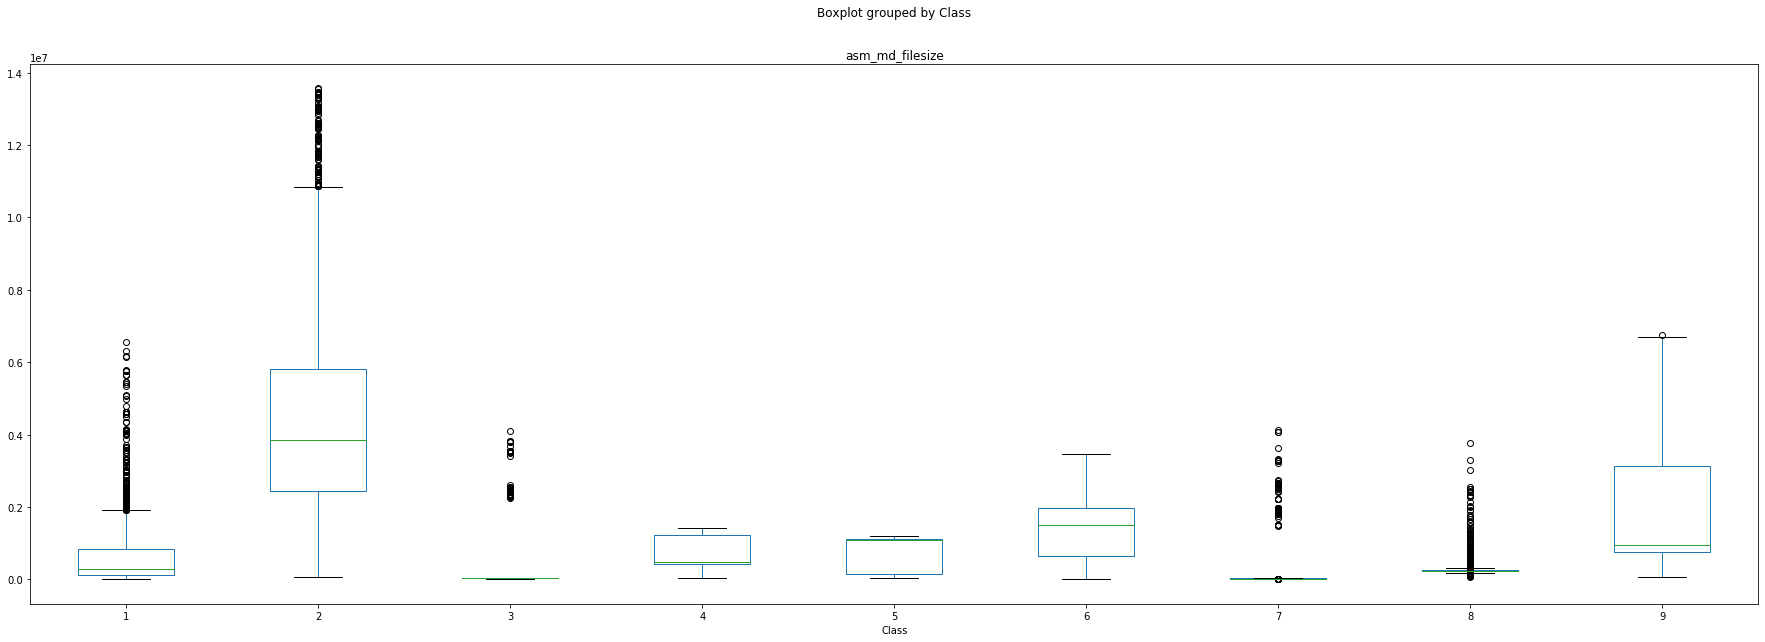

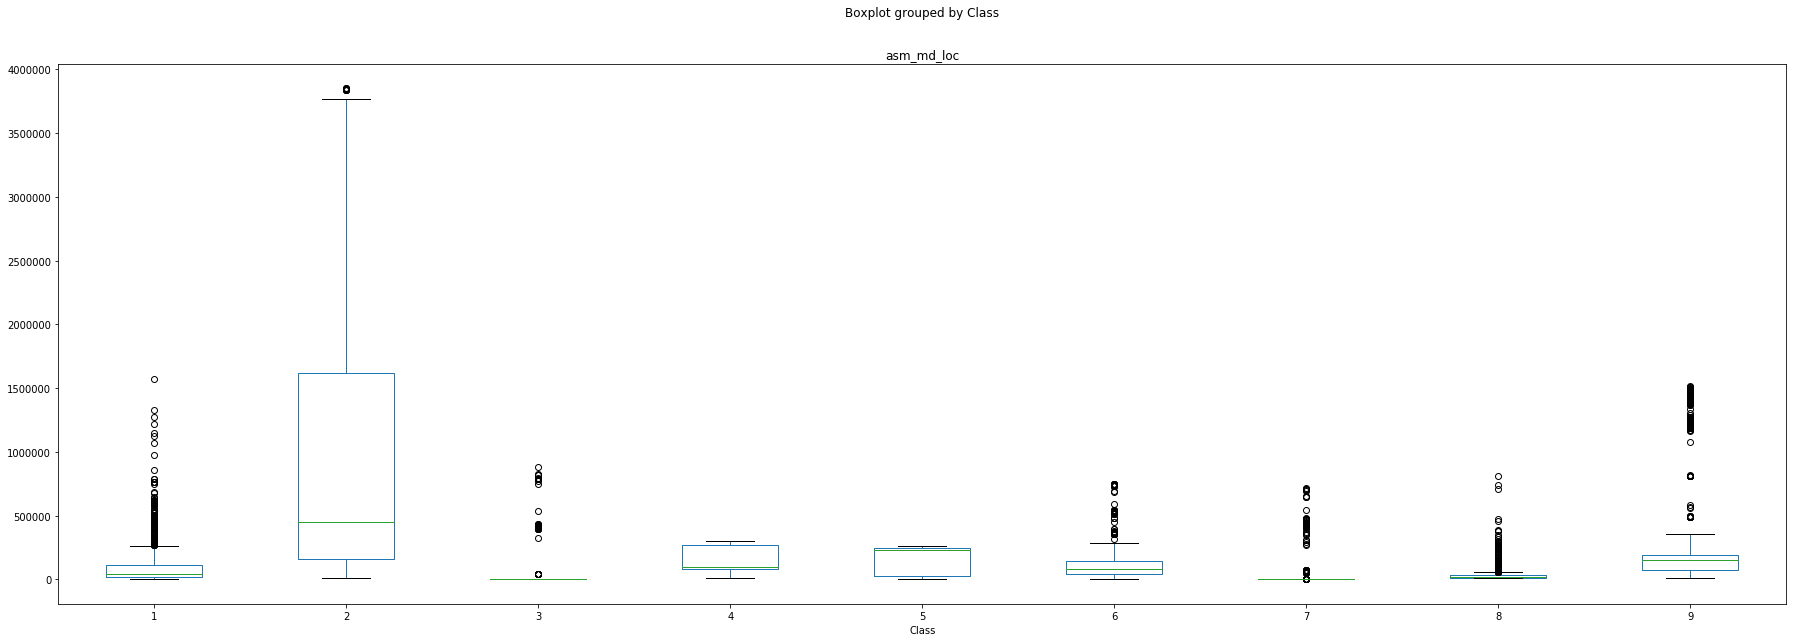

In [76]:
features.boxplot(column=[metadata_asm_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))
features.boxplot(column=[metadata_asm_features.columns.values[1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

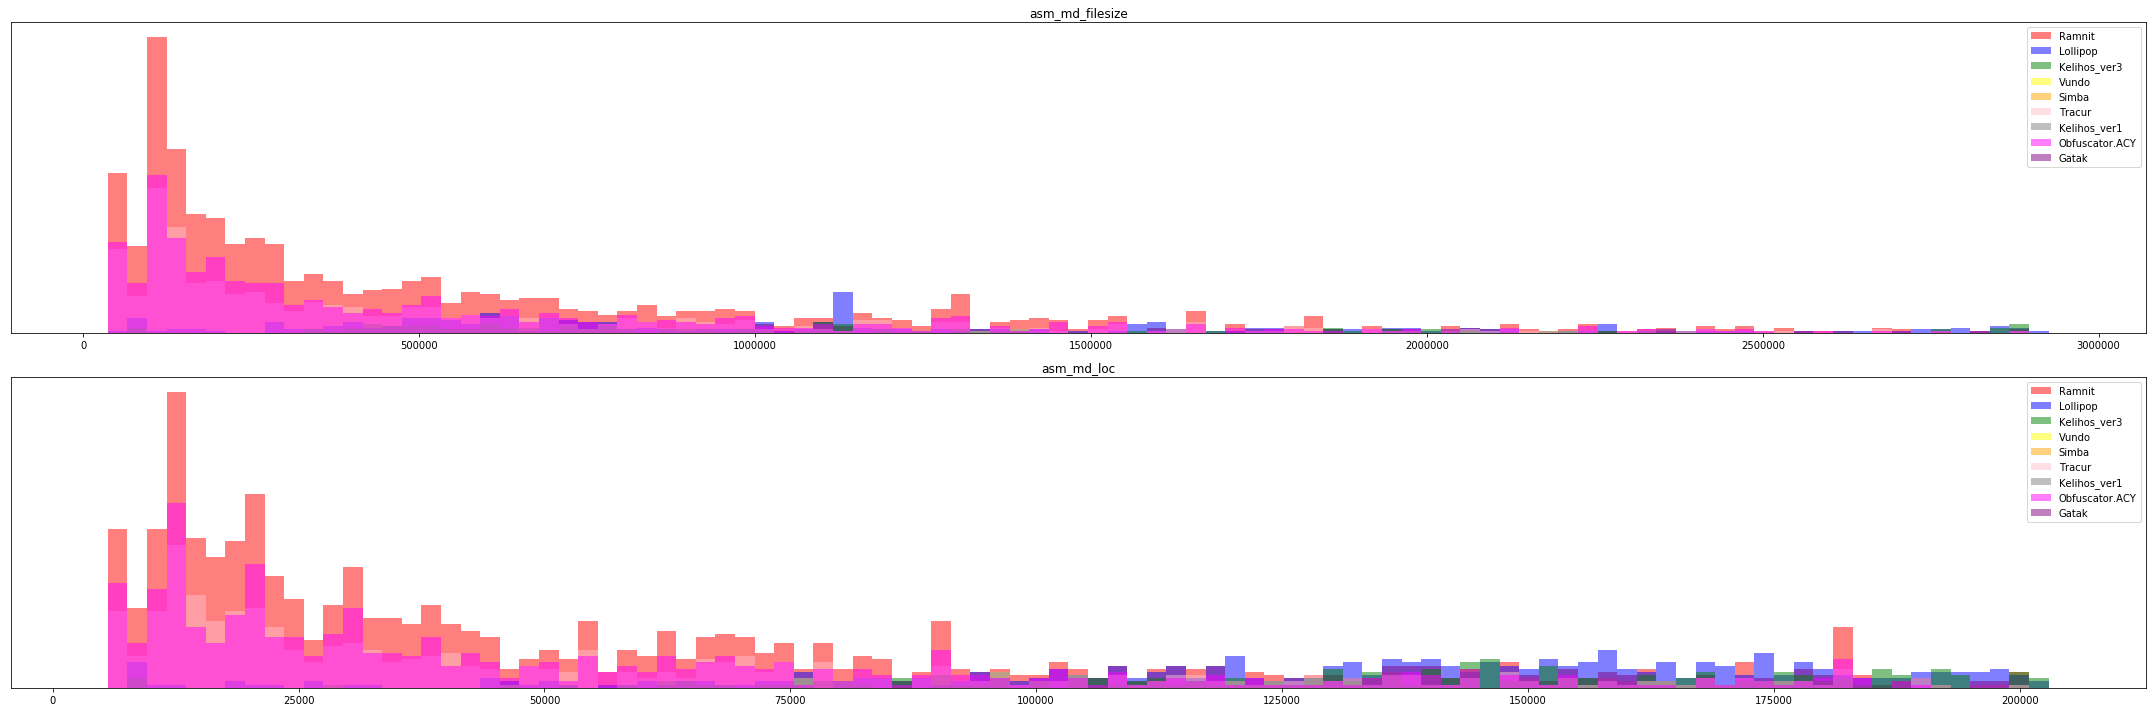

In [120]:
draw_histograms_rows_quantile( data = metadata_asm_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1], 
                              sections = 100, 
                              no_rows = 2, no_cols = 1, 
                              fig_x = 30, fig_y = 10,
                              i_want_whole_range = [False]*2)

#### simboli
_SYM_

In [58]:
# SYMBOLS značajke
symbols_features = features.iloc[:,632:639]
symbols_features.head()

,asm_symb_Star,asm_symb_Dash,asm_symb_Plus,asm_symb_Bracket_Open,asm_symb_Bracket_Close,asm_symb_AtSign,asm_symb_Question
0,10,94,216,125,125,34,53
1,6876,5085,14173,11375,11375,5551,5045
2,651,664,3263,2287,2287,1350,1349
3,826,14382,56341,41569,41573,24,608
4,123,774,3661,2663,2663,12,138


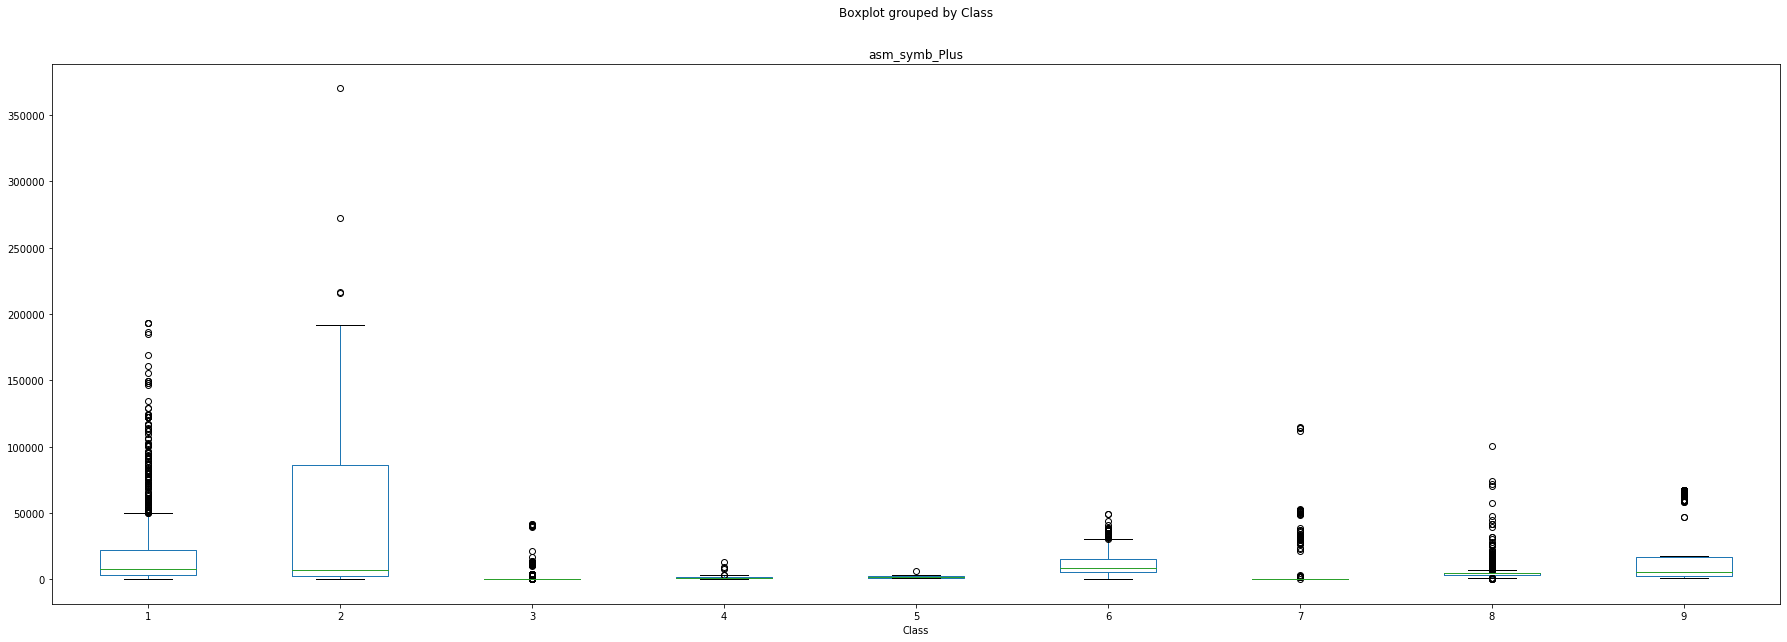

In [129]:
features.boxplot(column=[symbols_features.columns.values[2]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

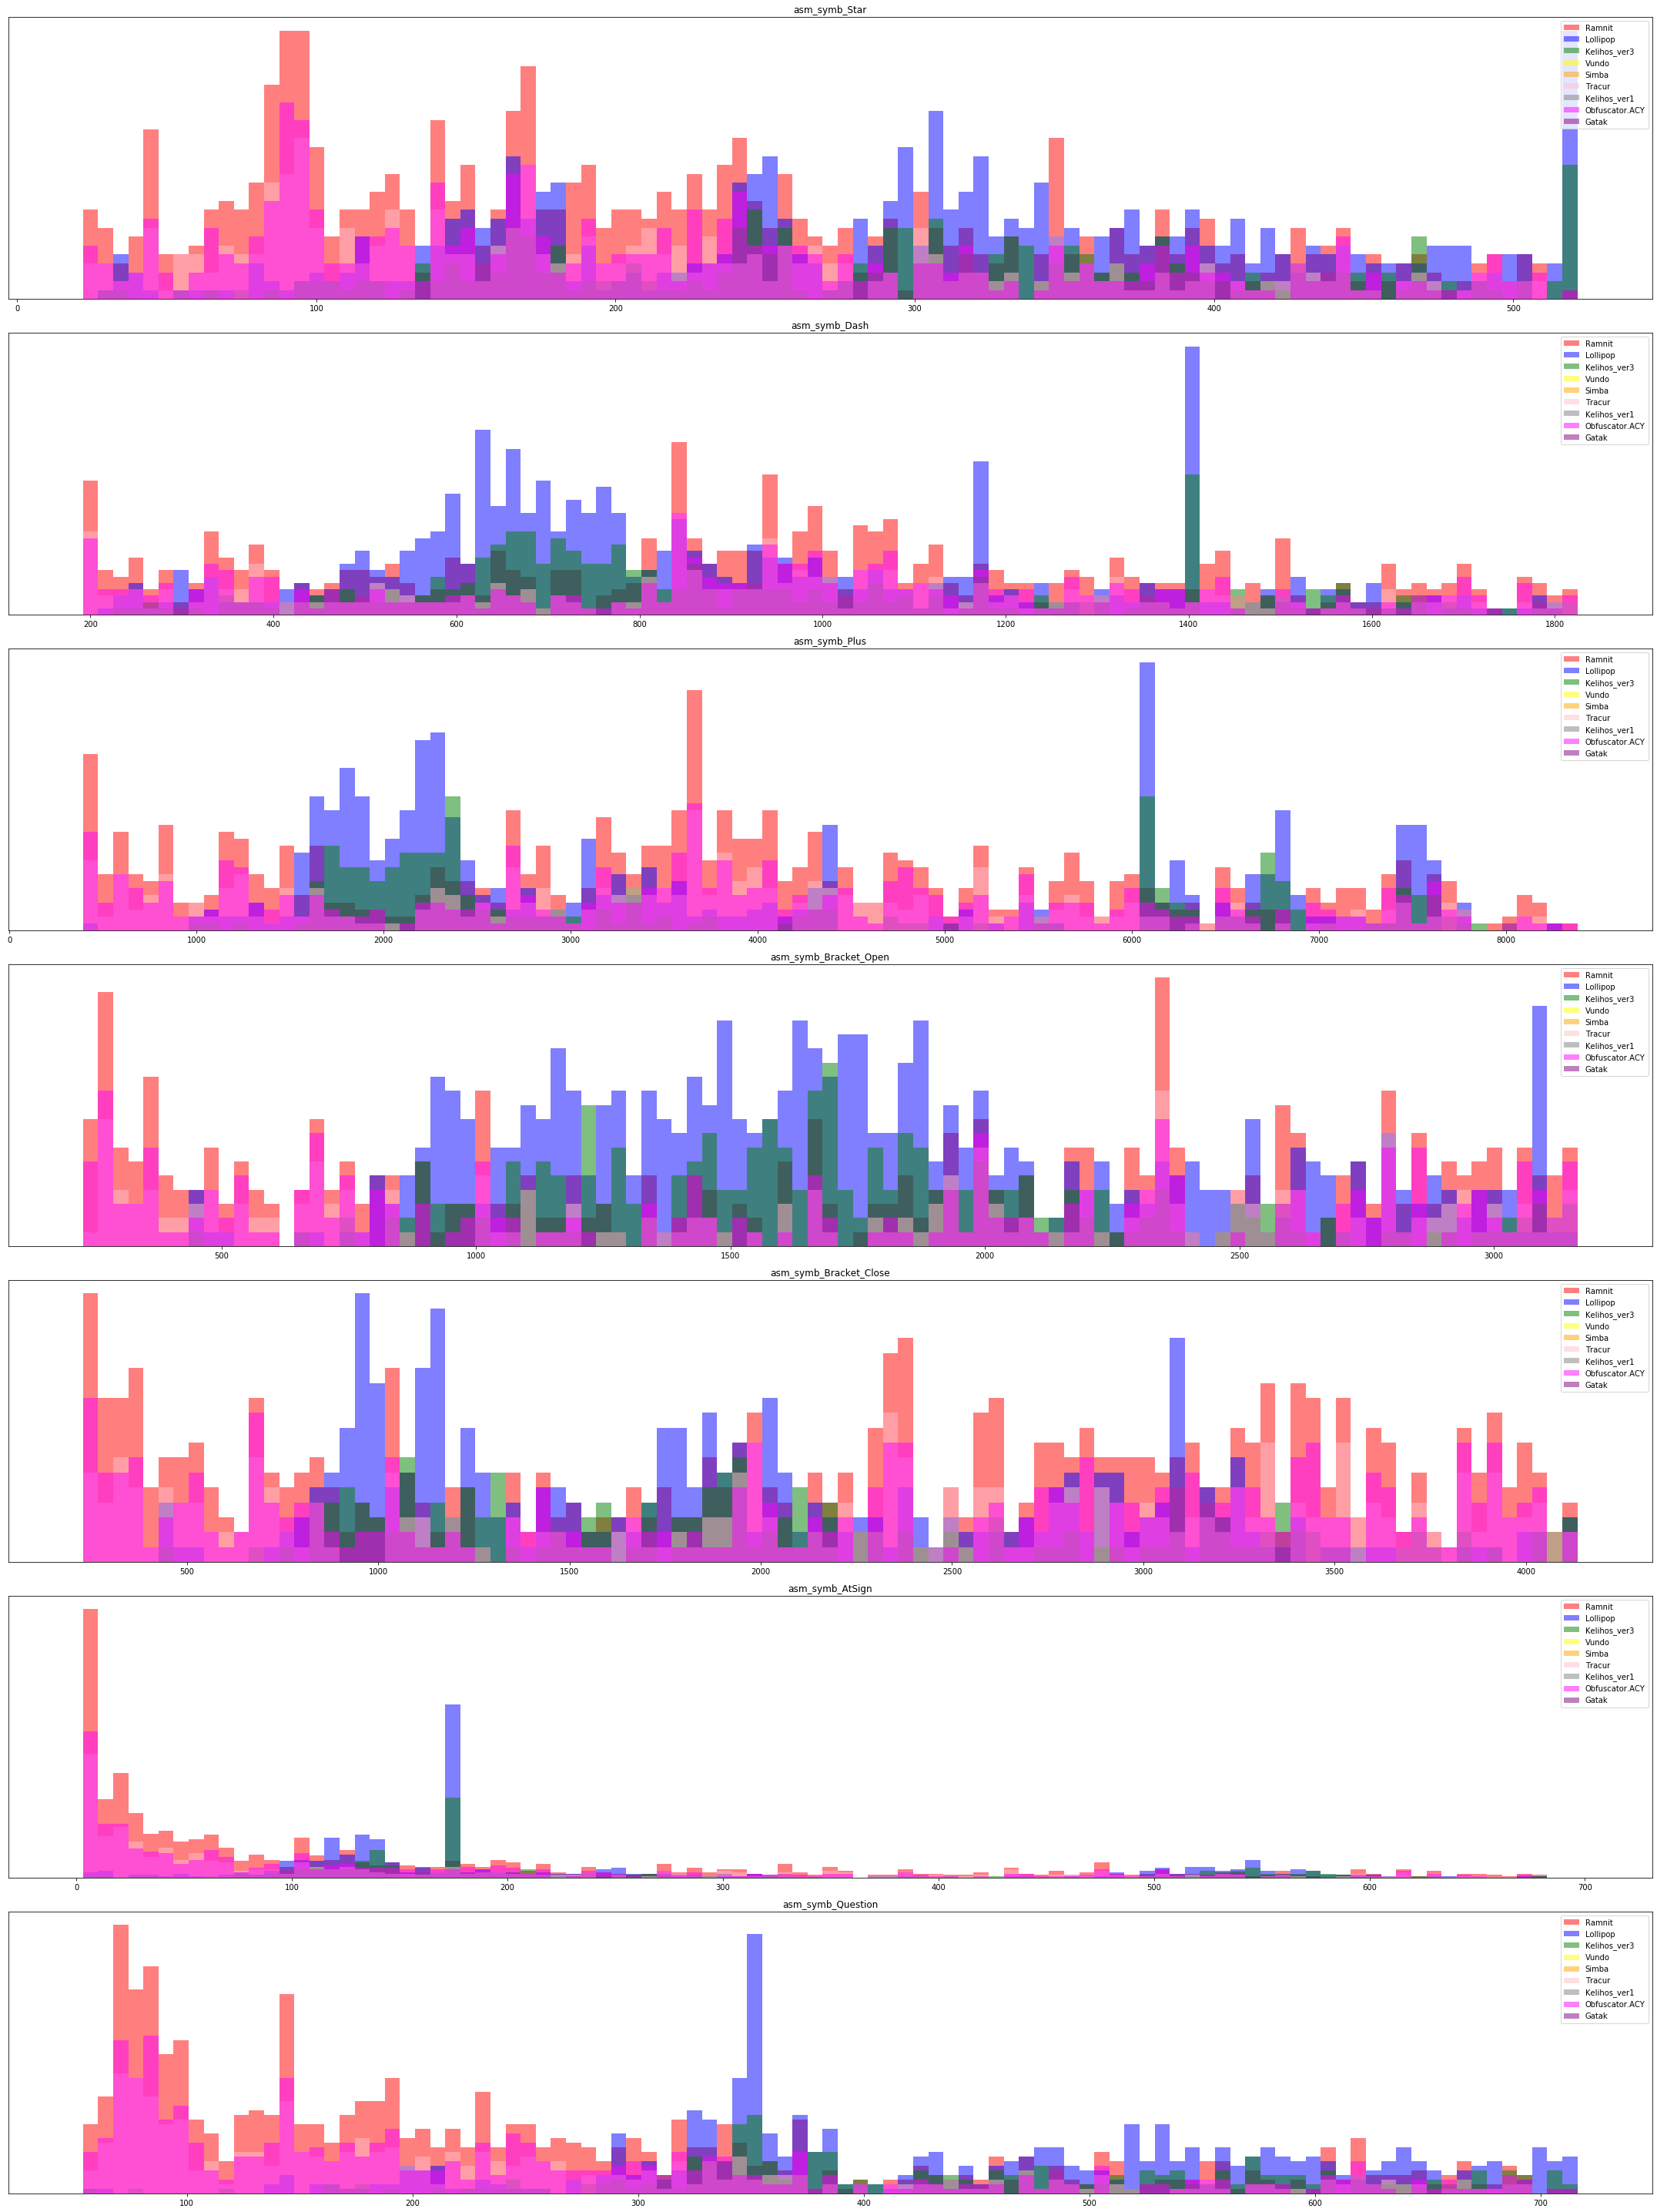

In [122]:
draw_histograms_rows_quantile( data = symbols_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [i for i in range(7)], 
                              sections = 100, 
                              no_rows = 7, no_cols = 1, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*7)

#### opcode
_OPC_

In [127]:
# OPCODE značajke
opcode_features = features.iloc[:,639:732]
opcode_features.head()

,asm_opcodes_add,asm_opcodes_al,asm_opcodes_bt,asm_opcodes_call,asm_opcodes_cdq,asm_opcodes_cld,asm_opcodes_cli,asm_opcodes_cmc,asm_opcodes_cmp,asm_opcodes_const,...,asm_opcodes_sidt,asm_opcodes_stc,asm_opcodes_std,asm_opcodes_sti,asm_opcodes_stos,asm_opcodes_sub,asm_opcodes_test,asm_opcodes_wait,asm_opcodes_xchg,asm_opcodes_xor
0,11,1,0,53,0,0,0,0,15,4,...,0,0,0,0,0,5,14,0,0,17
1,356,25,0,2900,1,0,0,0,1585,2259,...,0,0,0,0,0,311,817,0,1,739
2,176,31,0,461,2,0,0,0,320,123,...,0,0,0,0,0,73,183,0,0,180
3,1214,285,0,10686,25,5,1,0,7071,176,...,0,2,4,0,0,1240,4996,1,3,2901
4,532,2,0,462,2,1,0,0,539,5,...,0,0,0,0,0,221,362,0,38,254


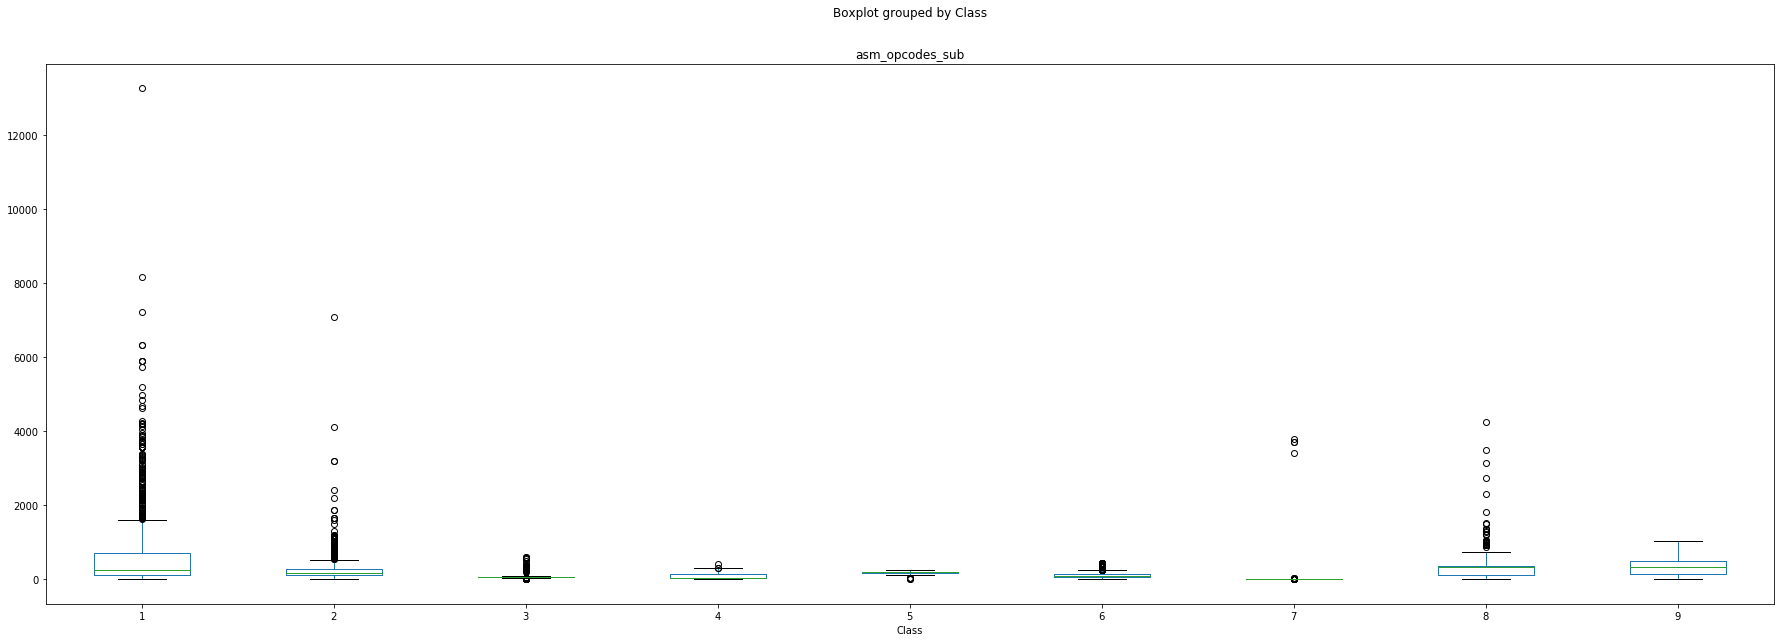

In [138]:
features.boxplot(column=[opcode_features.columns.values[-5]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

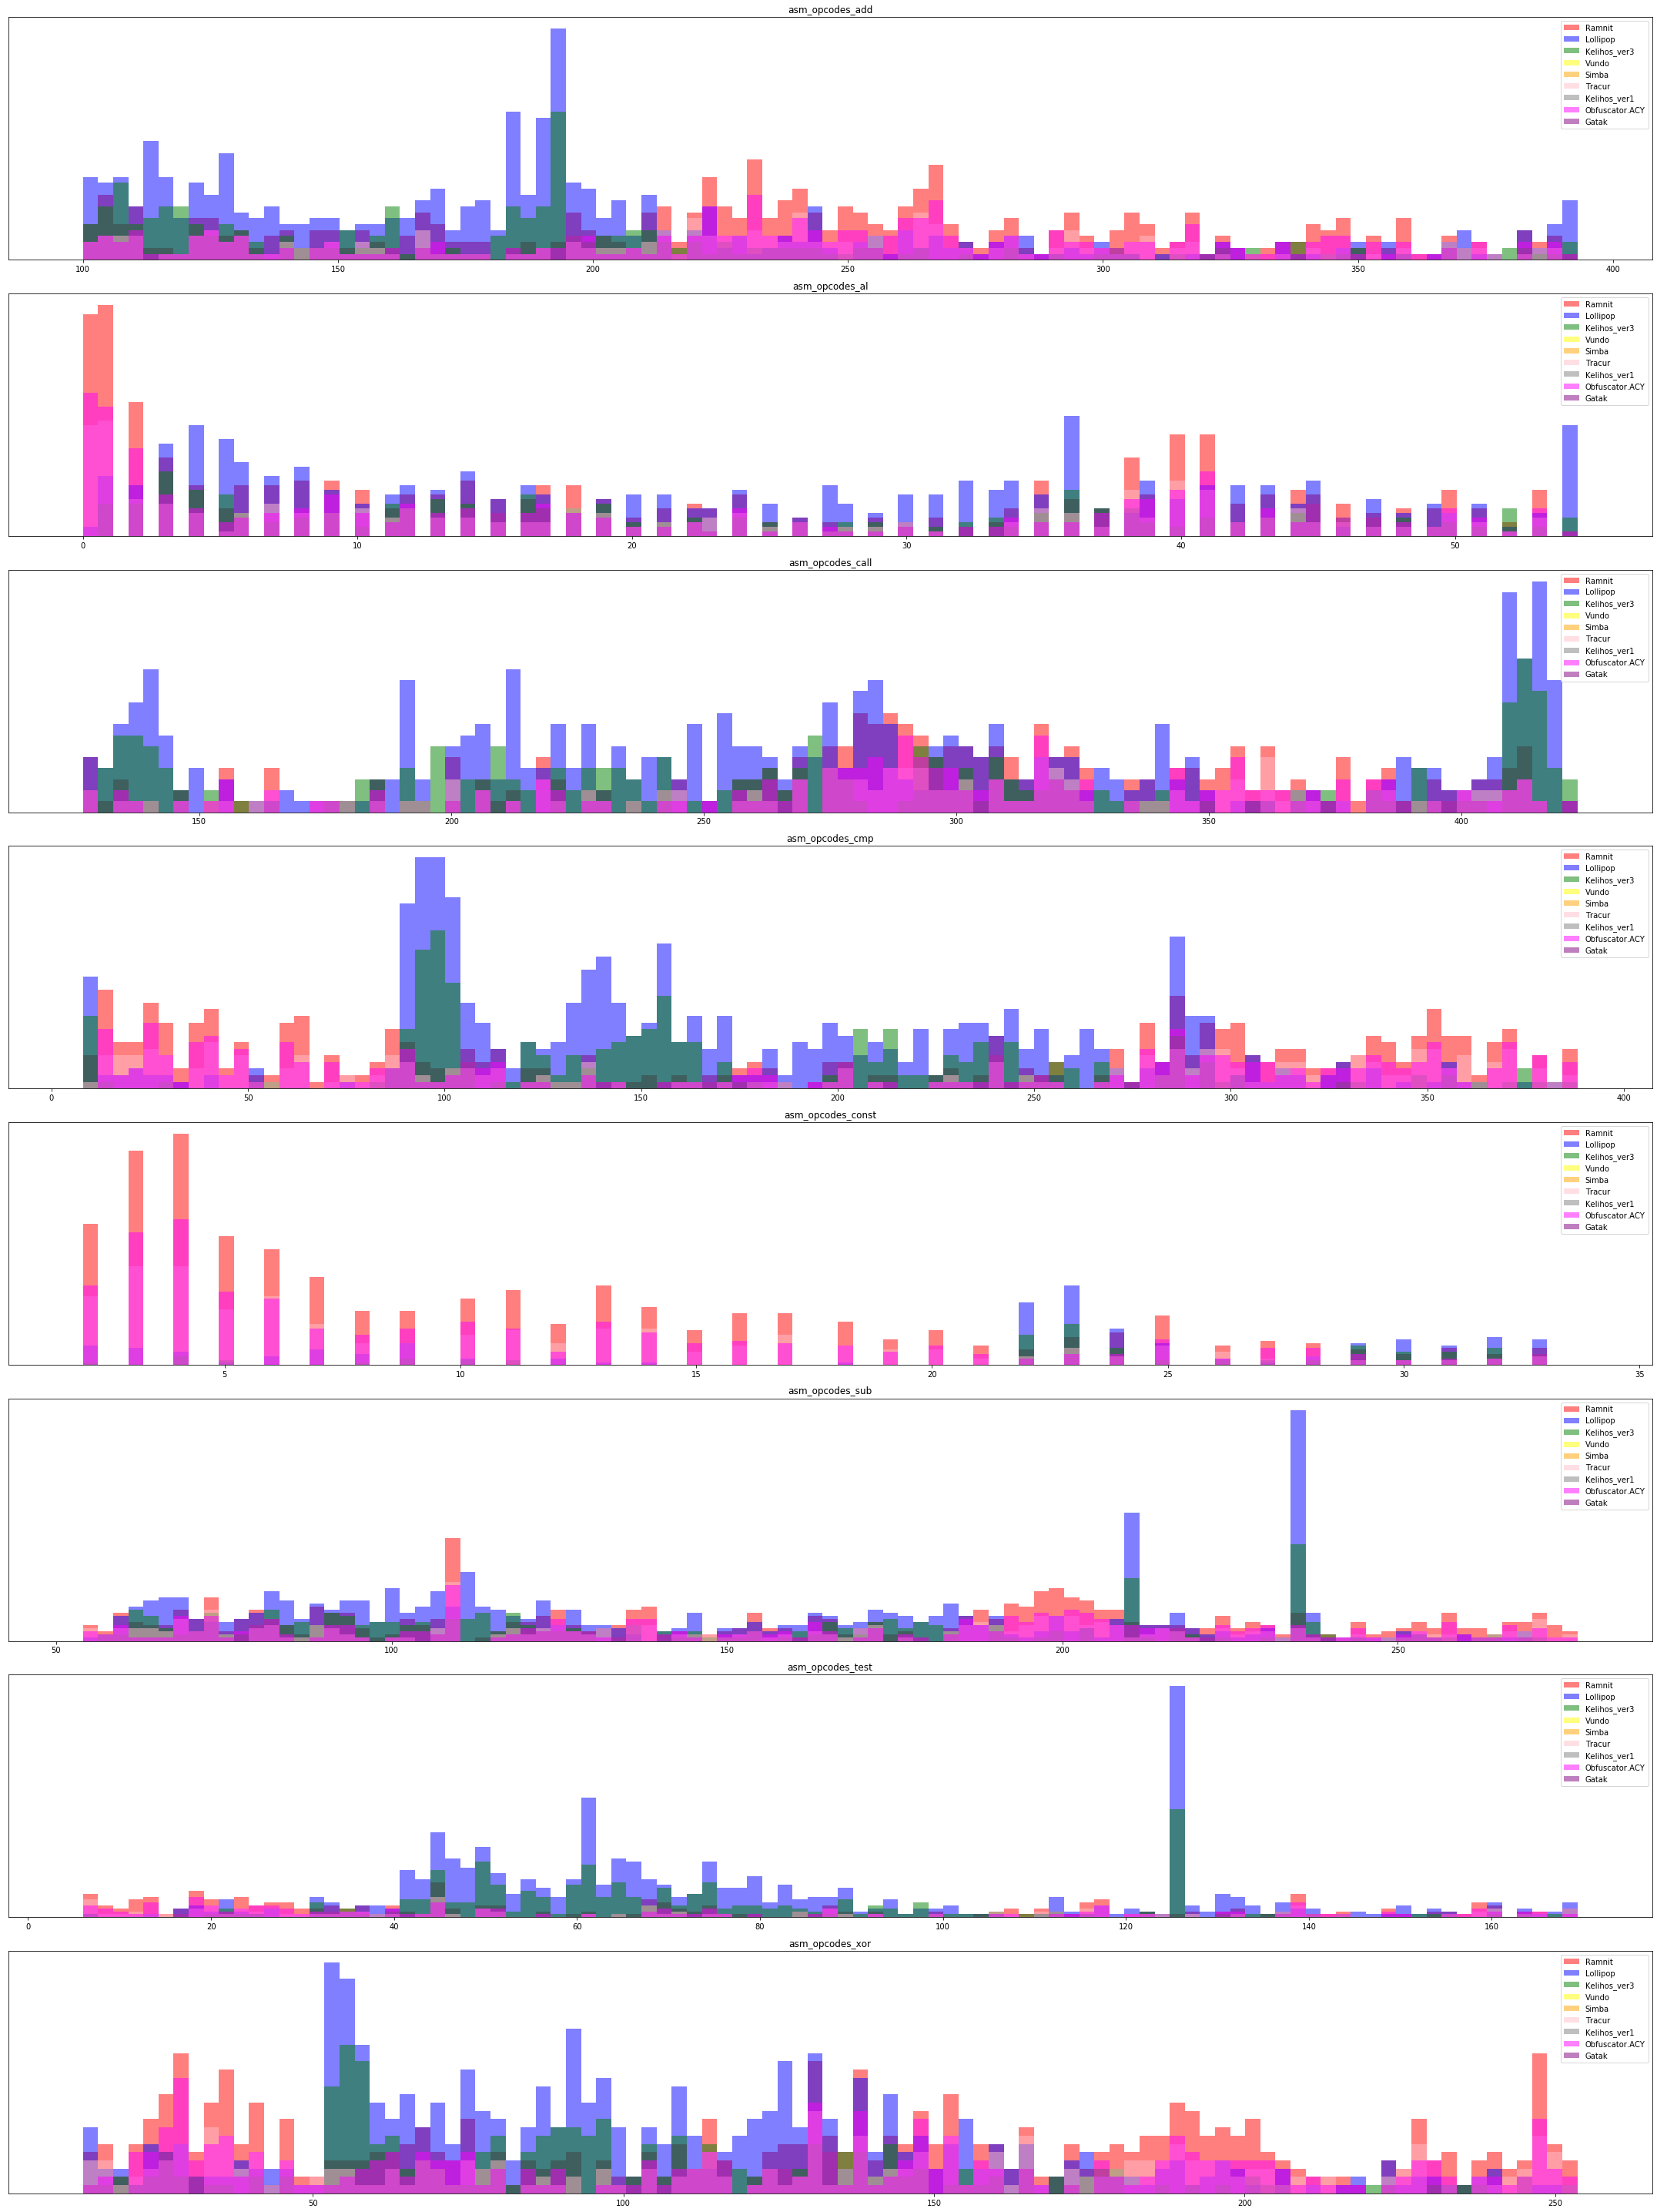

In [140]:
draw_histograms_rows_quantile( data = opcode_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,3,8,9,-5,-4,-1], 
                              sections = 100, 
                              no_rows = 8, no_cols = 1, 
                              fig_x = 30, fig_y = 40,
                              i_want_whole_range = [False]*8)

#### registri
_REG_

In [141]:
# REGISTER značajke
reg_features = features.iloc[:,732:758]
reg_features.head()

,asm_regs_edx,asm_regs_esi,asm_regs_es,asm_regs_fs,asm_regs_ds,asm_regs_ss,asm_regs_gs,asm_regs_cs,asm_regs_ah,asm_regs_al,...,asm_regs_cx,asm_regs_dh,asm_regs_dl,asm_regs_dx,asm_regs_eax,asm_regs_ebp,asm_regs_ebx,asm_regs_ecx,asm_regs_edi,asm_regs_esp
0,23,35,0,0,0,0,0,0,0,3,...,0,0,0,0,137,43,19,66,15,81
1,936,5027,1,1,1,1,1,1,3,45,...,33,4,15,20,9839,6382,2511,5024,3972,713
2,1011,895,0,1,0,0,1,0,0,60,...,4,0,15,0,2111,446,444,1378,562,730
3,3942,19687,1,1,1,2,1,1,28,597,...,94,8,232,46,41449,28751,11489,15737,16619,2832
4,1058,1402,1,1,1,1,1,1,0,22,...,2,0,5,0,2637,930,930,1561,1240,844


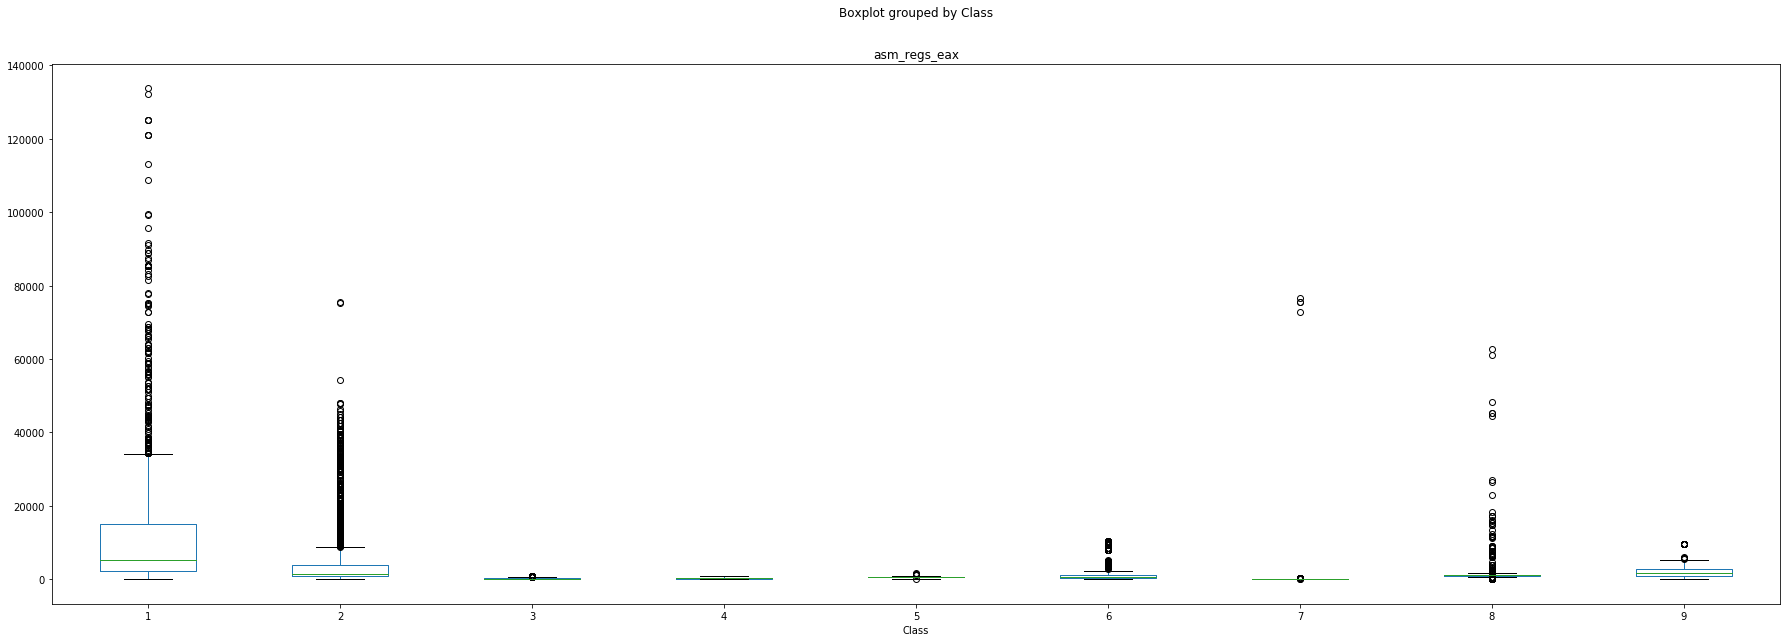

In [144]:
features.boxplot(column=[reg_features.columns.values[-6]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

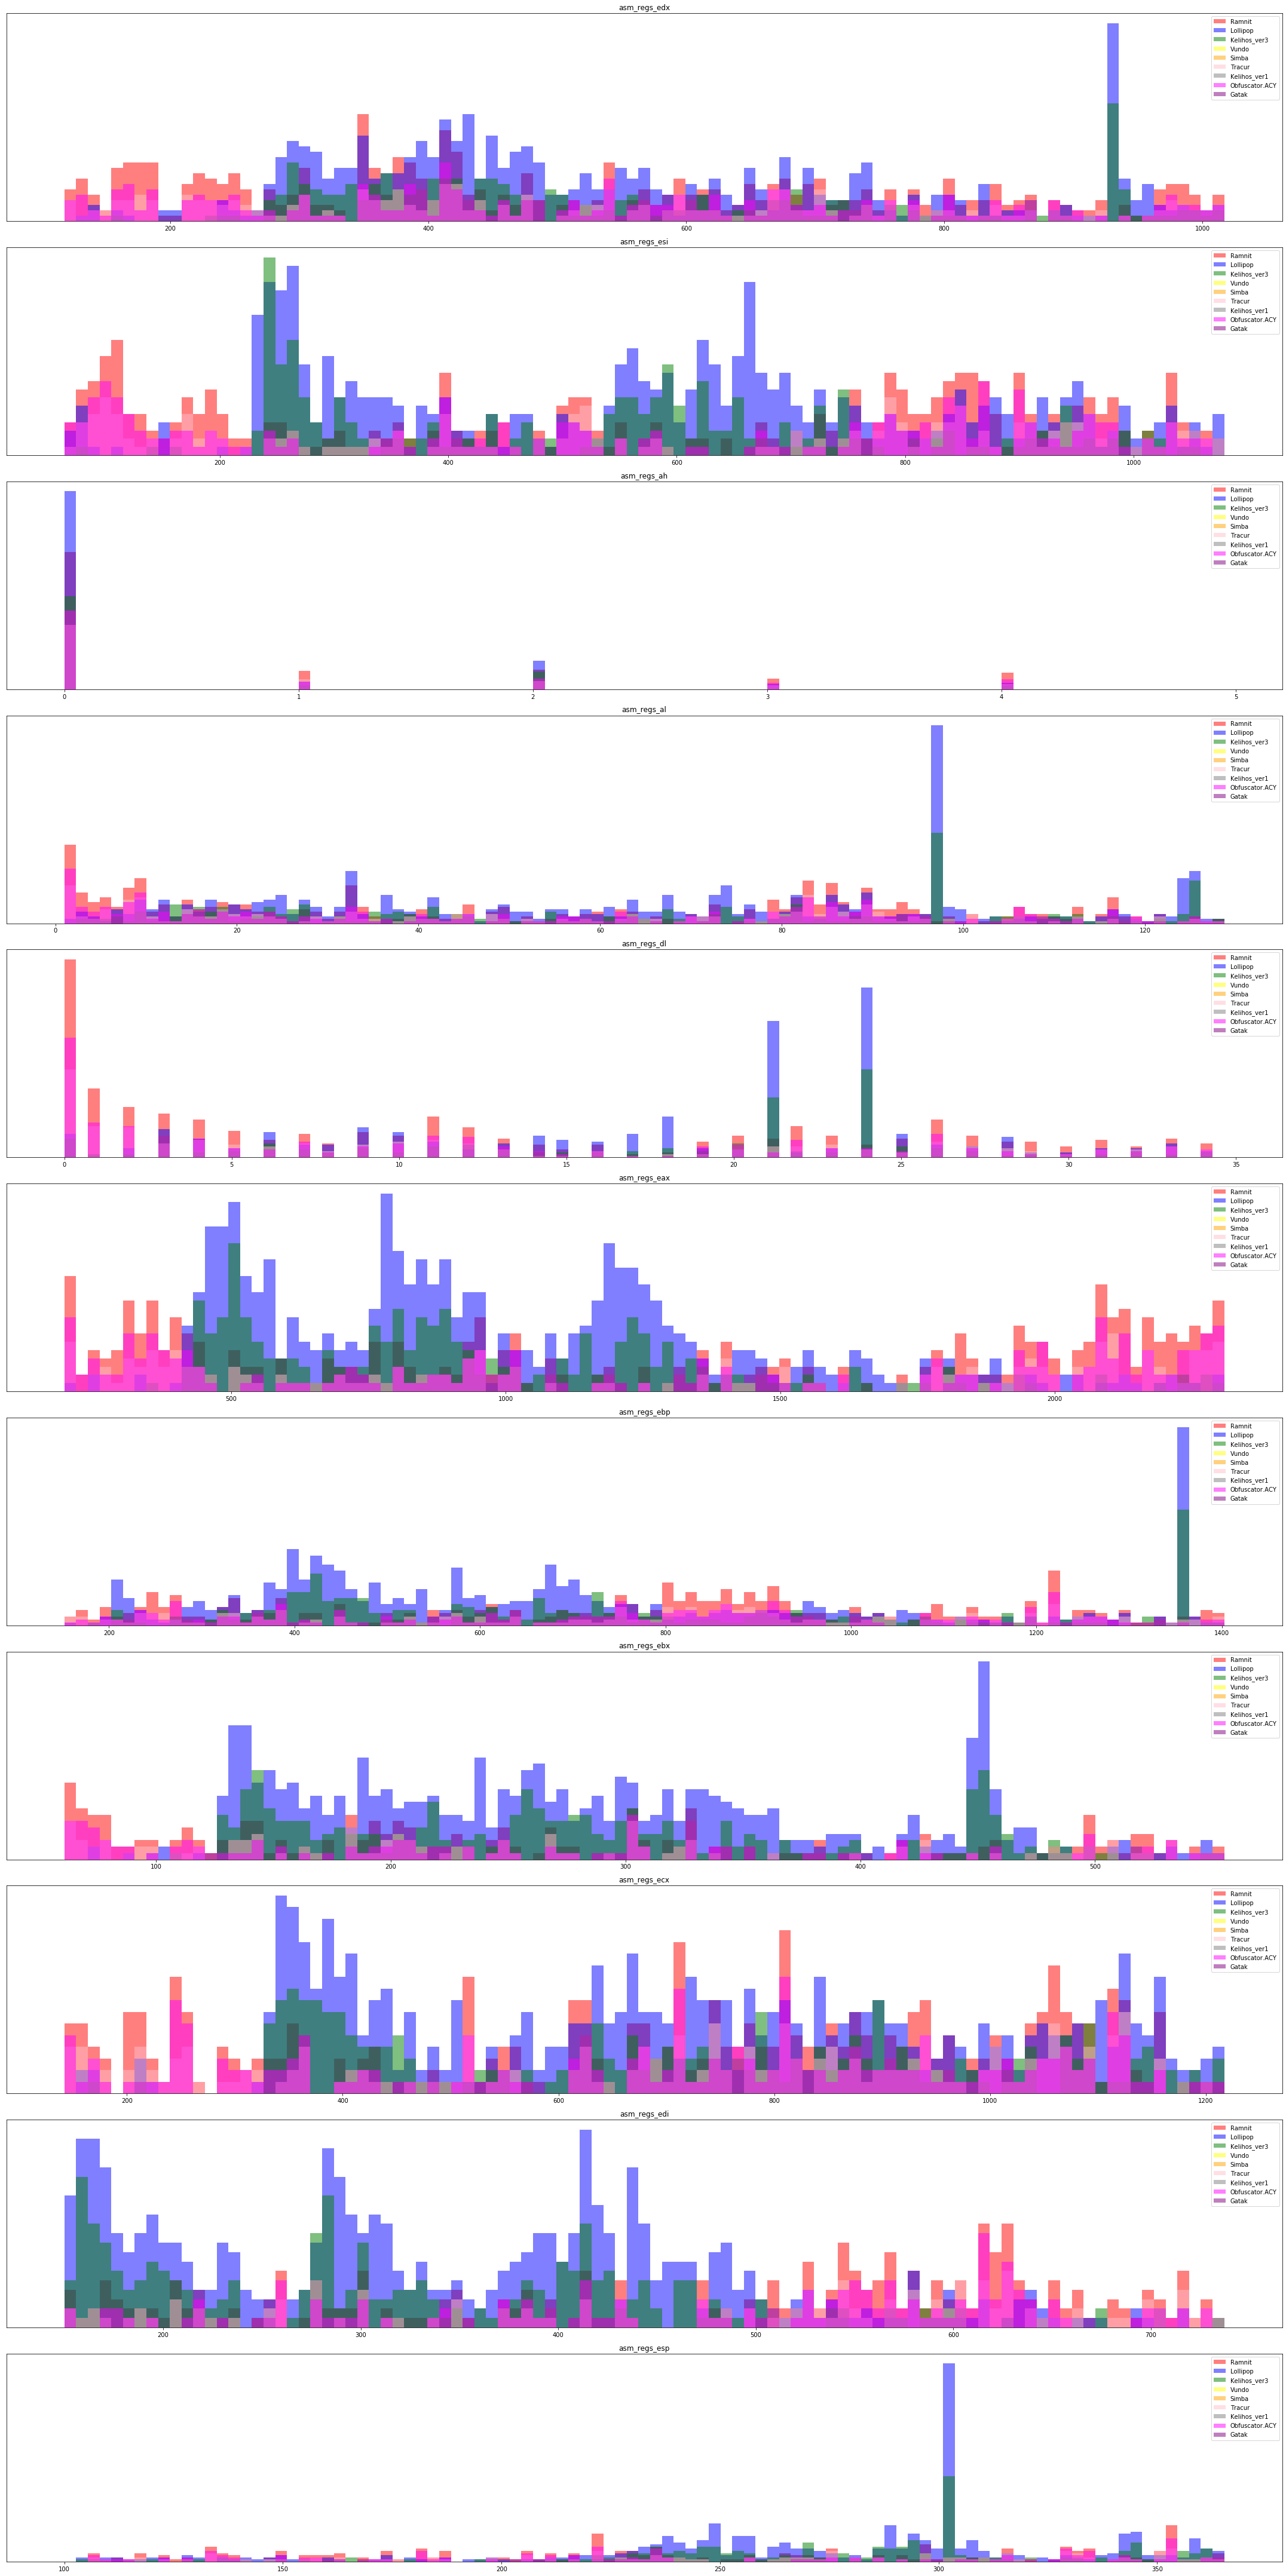

In [152]:
draw_histograms_rows_quantile( data = reg_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,8,9,-8,-6,-5,-4,-3,-2,-1],
                              sections = 100, 
                              no_rows = 11, no_cols = 1, 
                              fig_x = 30, fig_y = 60,
                              i_want_whole_range = [False]*11)

#### sekcije
_SEC_

In [147]:
# SECTION značajke
section_features = features.iloc[:,758:782]
section_features.head()

,.text,.data,.bss,.rdata,.edata,.idata,.rsrc,.tls,.reloc,Num_Sections,...,.bss_por,.rdata_por,.edata_por,.idata_por,.rsrc_por,.tls_por,.reloc_por,known_Sections_por,Unknown_Sections_por,Unknown_Sections_lines_por
0,744.0,57.0,0.0,323.0,0.0,127.0,3.0,0.0,3.0,7.0,...,0.0,0.253135,0.0,0.099530,0.002351,0.0,0.0,0.714286,0.142857,0.014890
1,60476.0,3760.0,0.0,0.0,0.0,349.0,3.0,0.0,3.0,6.0,...,0.0,0.000000,0.0,0.005402,0.000046,0.0,0.0,0.666667,0.166667,0.000294
2,11119.0,1047.0,0.0,3385.0,0.0,323.0,3.0,0.0,3.0,7.0,...,0.0,0.212933,0.0,0.020318,0.000189,0.0,0.0,0.714286,0.142857,0.001069
3,208048.0,19267.0,0.0,0.0,0.0,1746.0,3.0,0.0,3.0,7.0,...,0.0,0.000000,0.0,0.007546,0.000013,0.0,0.0,0.571429,0.285714,0.010031
4,12773.0,3160.0,0.0,639.0,0.0,230.0,3.0,0.0,3.0,7.0,...,0.0,0.037975,0.0,0.013669,0.000178,0.0,0.0,0.714286,0.142857,0.001129


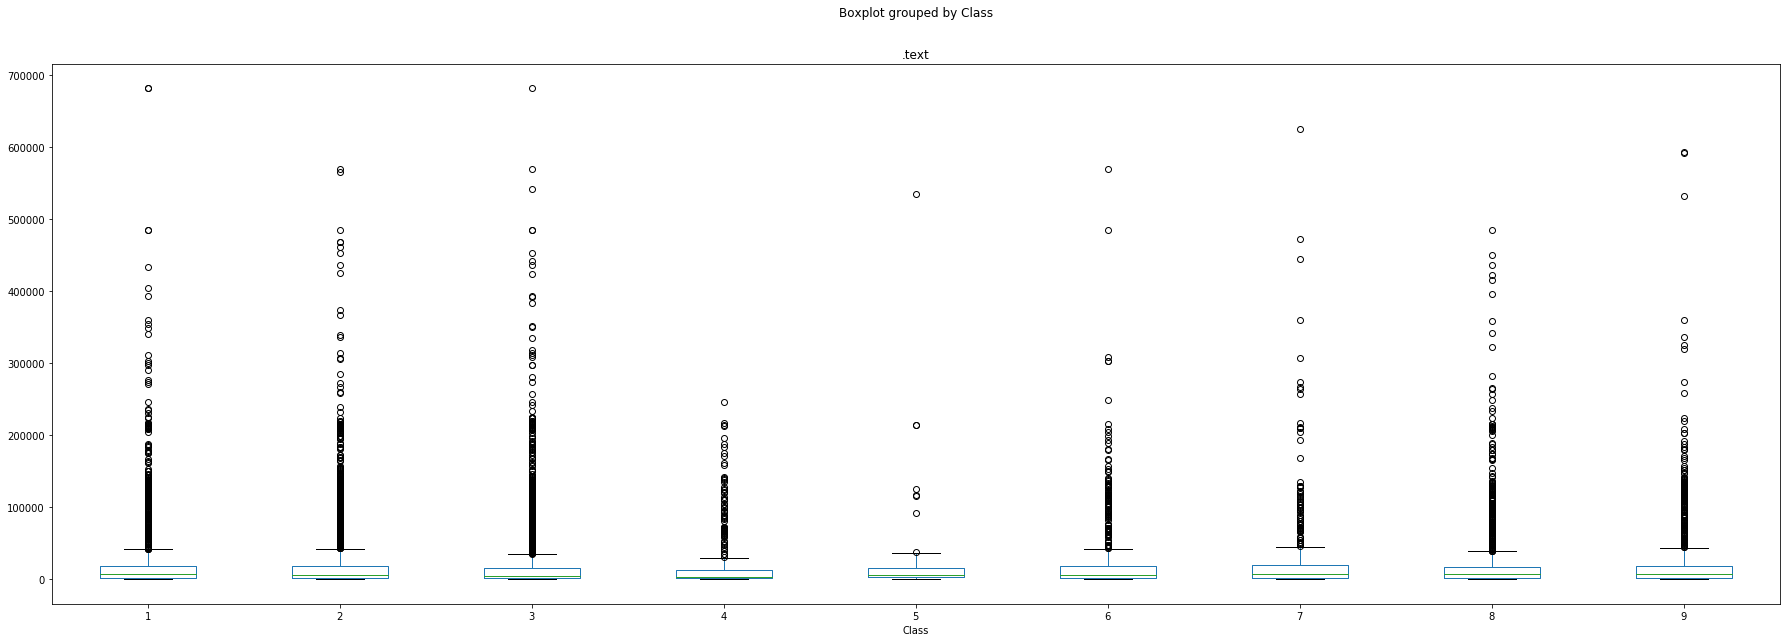

In [151]:
features.boxplot(column=[section_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

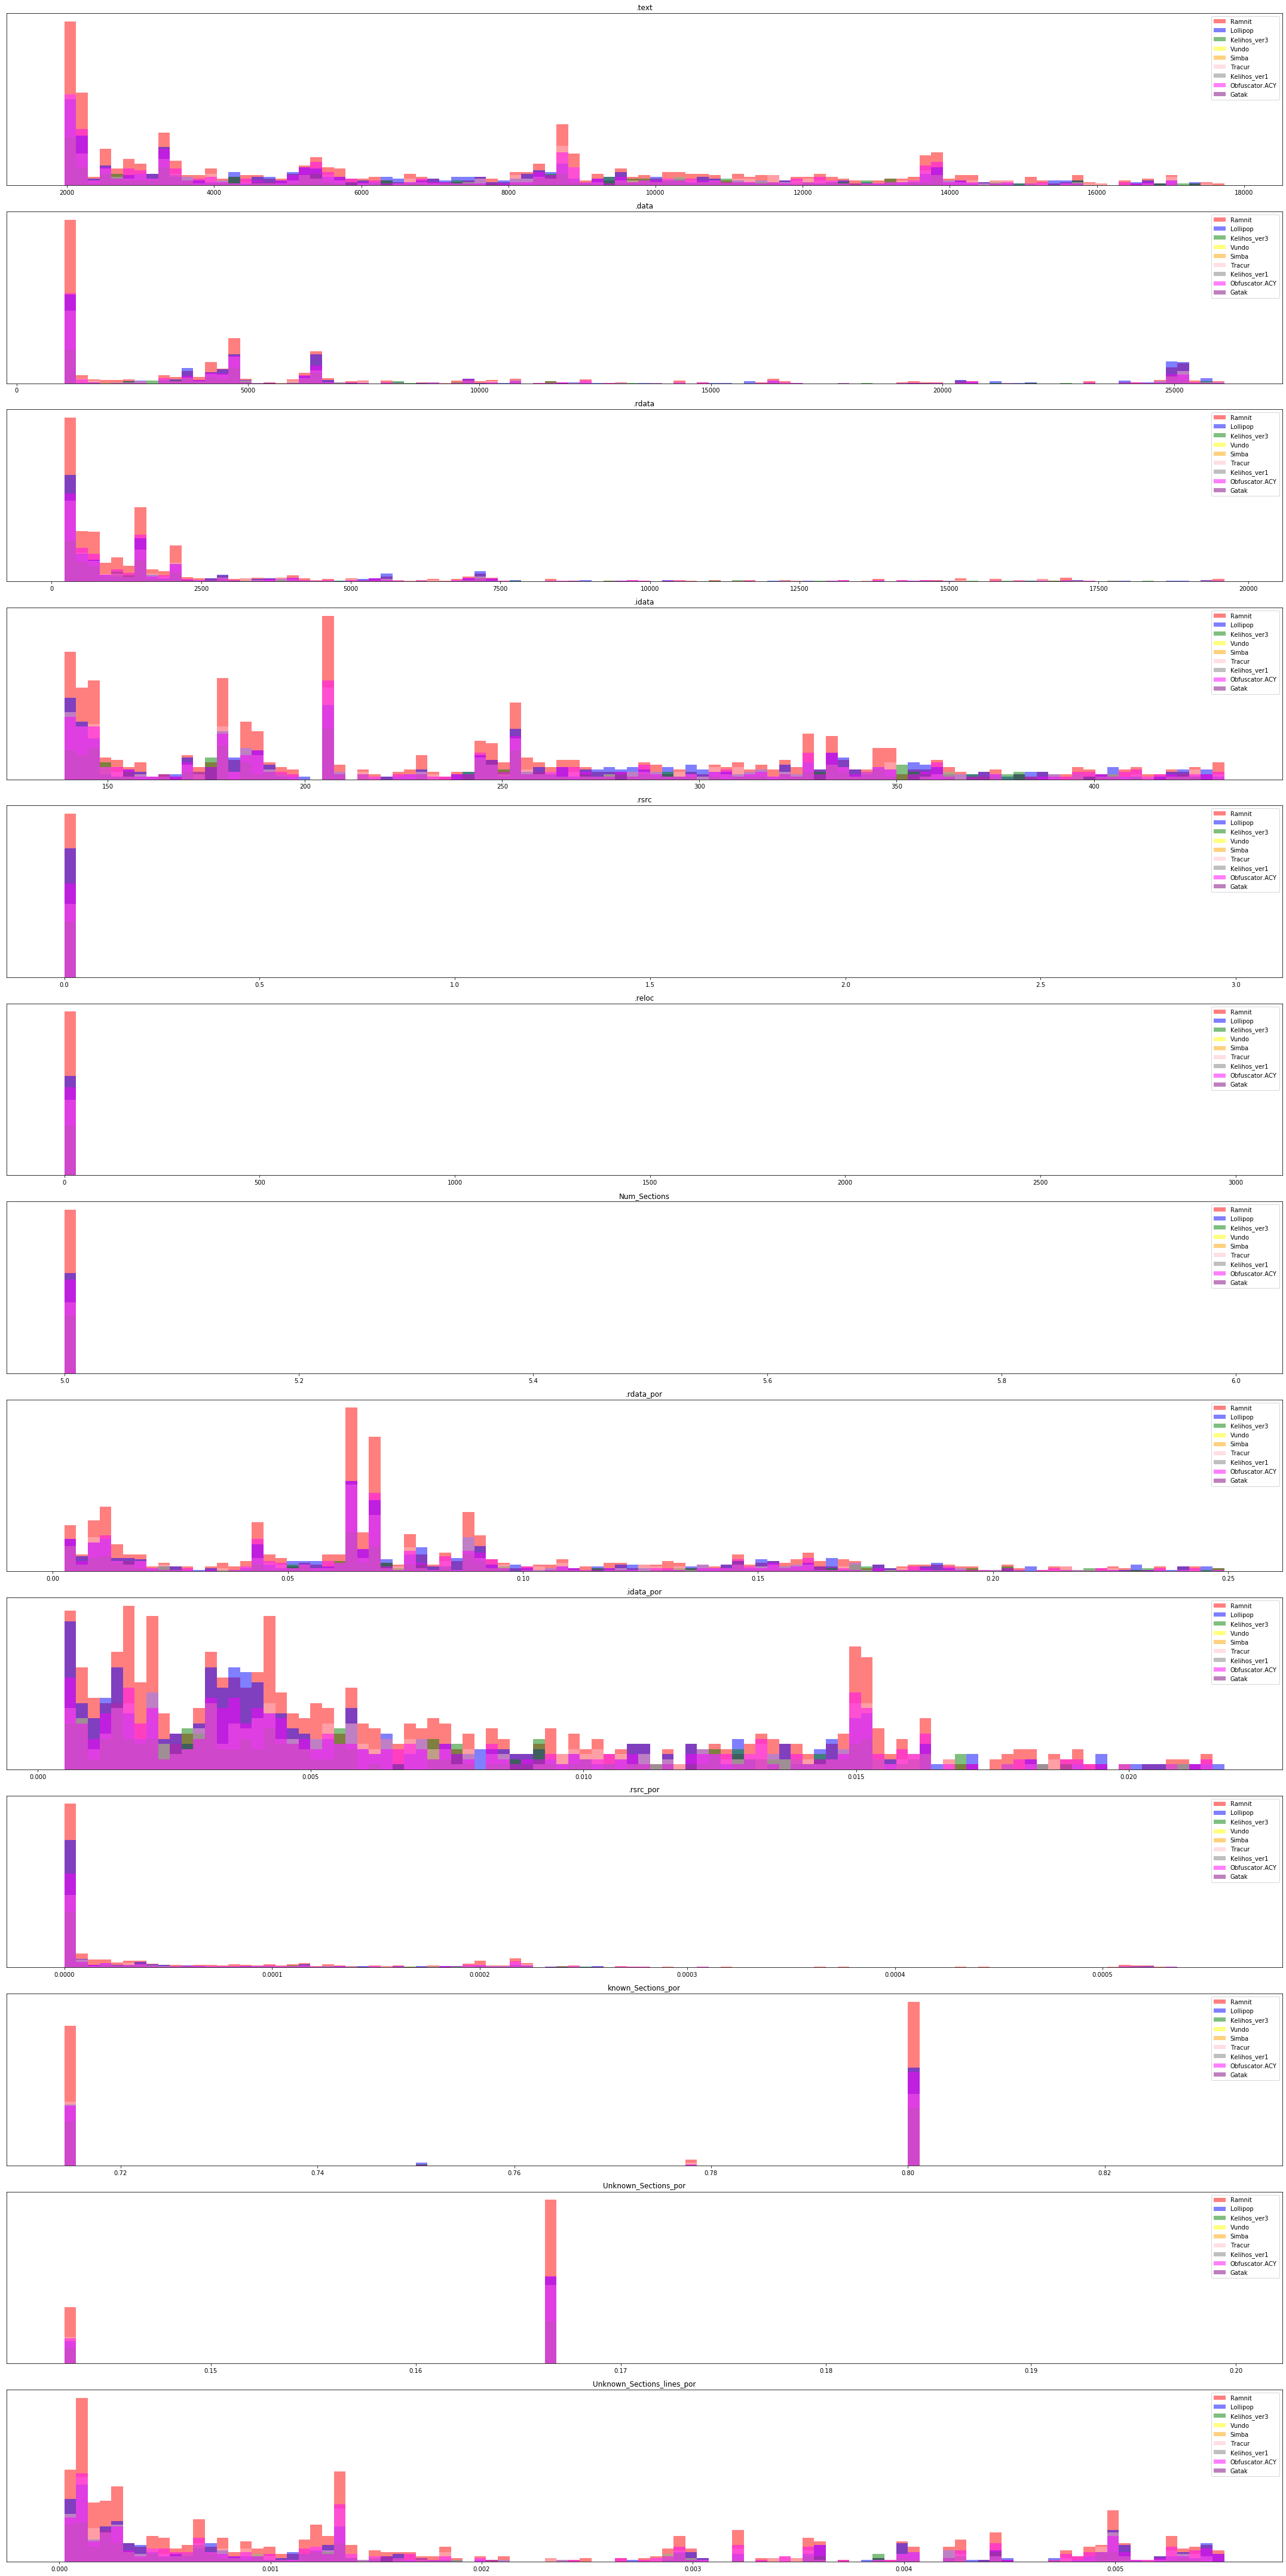

In [157]:
draw_histograms_rows_quantile( data = section_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,3,5,6,8,9,-9,-7,-6,-3,-2,-1],
                              sections = 100, 
                              no_rows = 13, no_cols = 1, 
                              fig_x = 30, fig_y = 60,
                              i_want_whole_range = [False]*13)

#### _data define_
_DP_

In [158]:
# DATA DEFINE značajke
dd_features = features.iloc[:,782:806]
dd_features.head()

,db_por,dd_por,dw_por,dc_por,db0_por,dbN0_por,dd_text,db_text,dd_rdata,db3_rdata,...,dd6,dd4_all,dd5_all,dd6_all,db3_idata,db3_NdNt,dd4_NdNt,dd5_NdNt,dd6_NdNt,db3_all_zero
0,0.108934,0.083072,0.029781,0.221787,0.474820,0.525180,0.008065,0.001344,0.287926,0.191950,...,0.0,0.000000,0.002351,0.000000,0.0,0.0,0.000000,0.003822,0.000000,0.370787
1,0.064309,0.048305,0.005262,0.117876,0.525150,0.474850,0.044414,0.021744,0.000000,0.000000,...,9.0,0.001068,0.000542,0.000139,0.0,0.0,0.001561,0.000792,0.000204,0.396007
2,0.185570,0.057369,0.006857,0.249796,0.647119,0.352881,0.000540,0.000540,0.250222,0.486263,...,0.0,0.000252,0.000503,0.000000,0.0,0.0,0.000442,0.000884,0.000000,0.376826
3,0.089382,0.017417,0.002178,0.108977,0.727589,0.272411,0.015506,0.015775,0.000000,0.000000,...,106.0,0.000337,0.000471,0.000458,0.0,0.0,0.000619,0.000876,0.000852,0.435593
4,0.194687,0.015273,0.004814,0.214774,0.902320,0.097680,0.002584,0.000470,0.270736,0.128326,...,0.0,0.000238,0.000178,0.000000,0.0,0.0,0.000496,0.000372,0.000000,0.474631


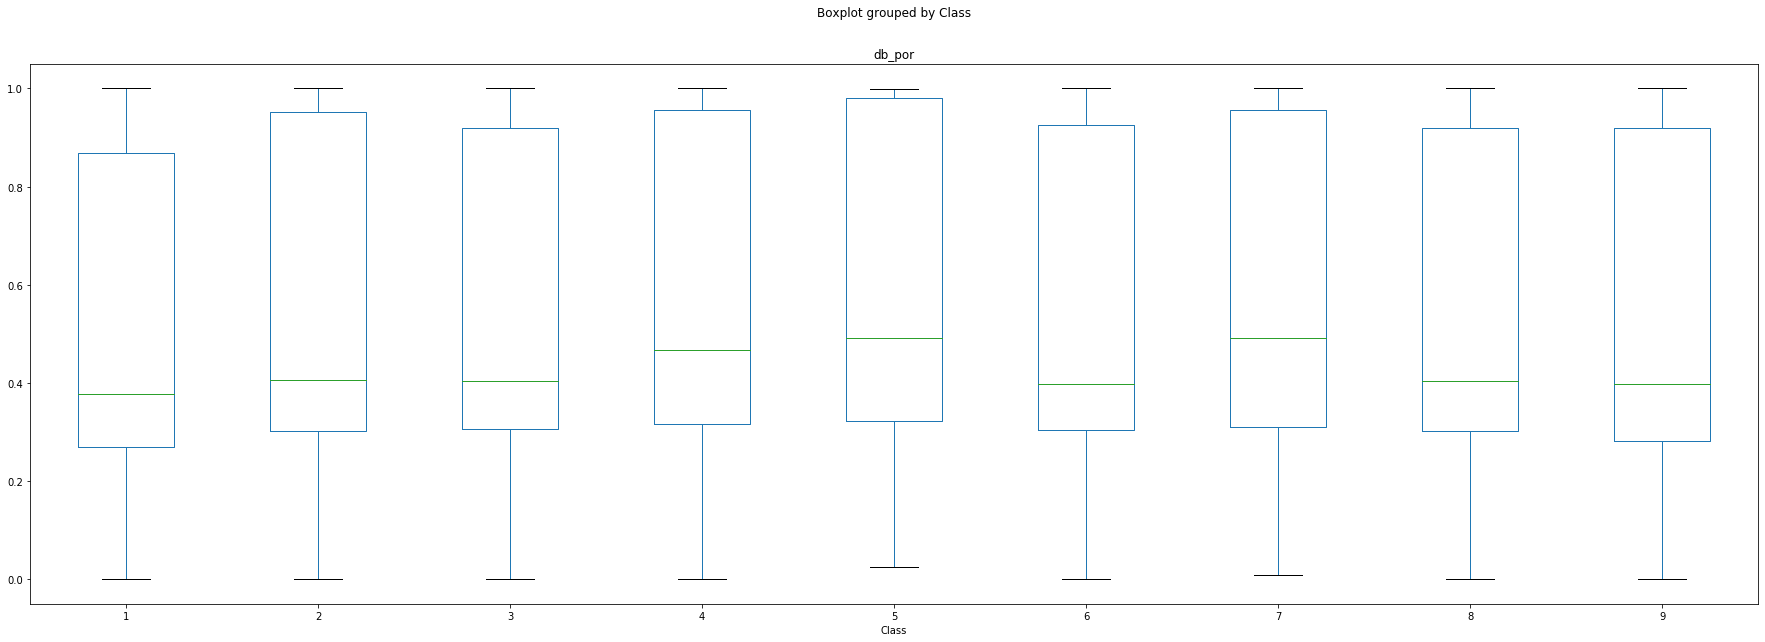

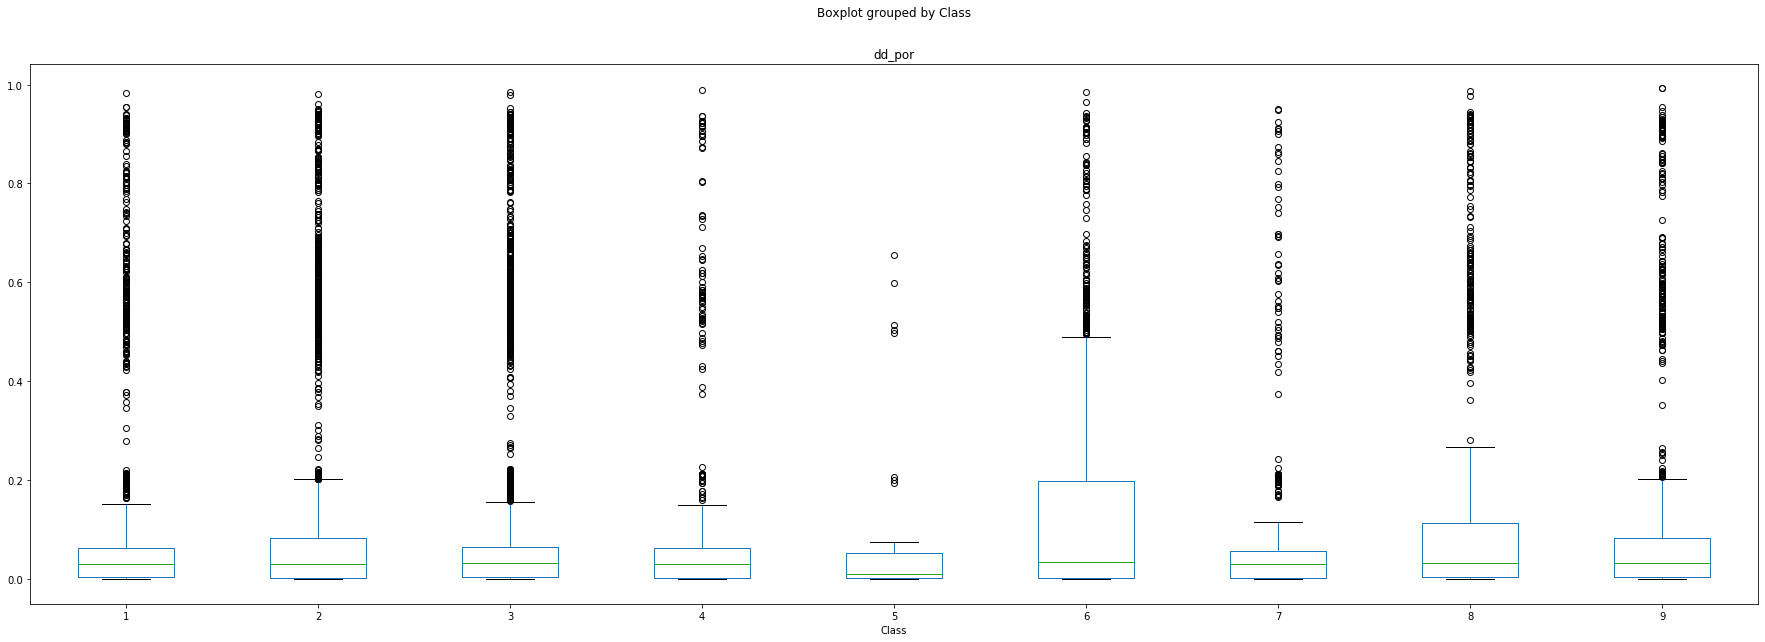

In [160]:
features.boxplot(column=[dd_features.columns.values[0]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))
features.boxplot(column=[dd_features.columns.values[1]], 
                 by='Class',
                 grid=False,
                 layout=(1,1),
                 figsize=(30,10))

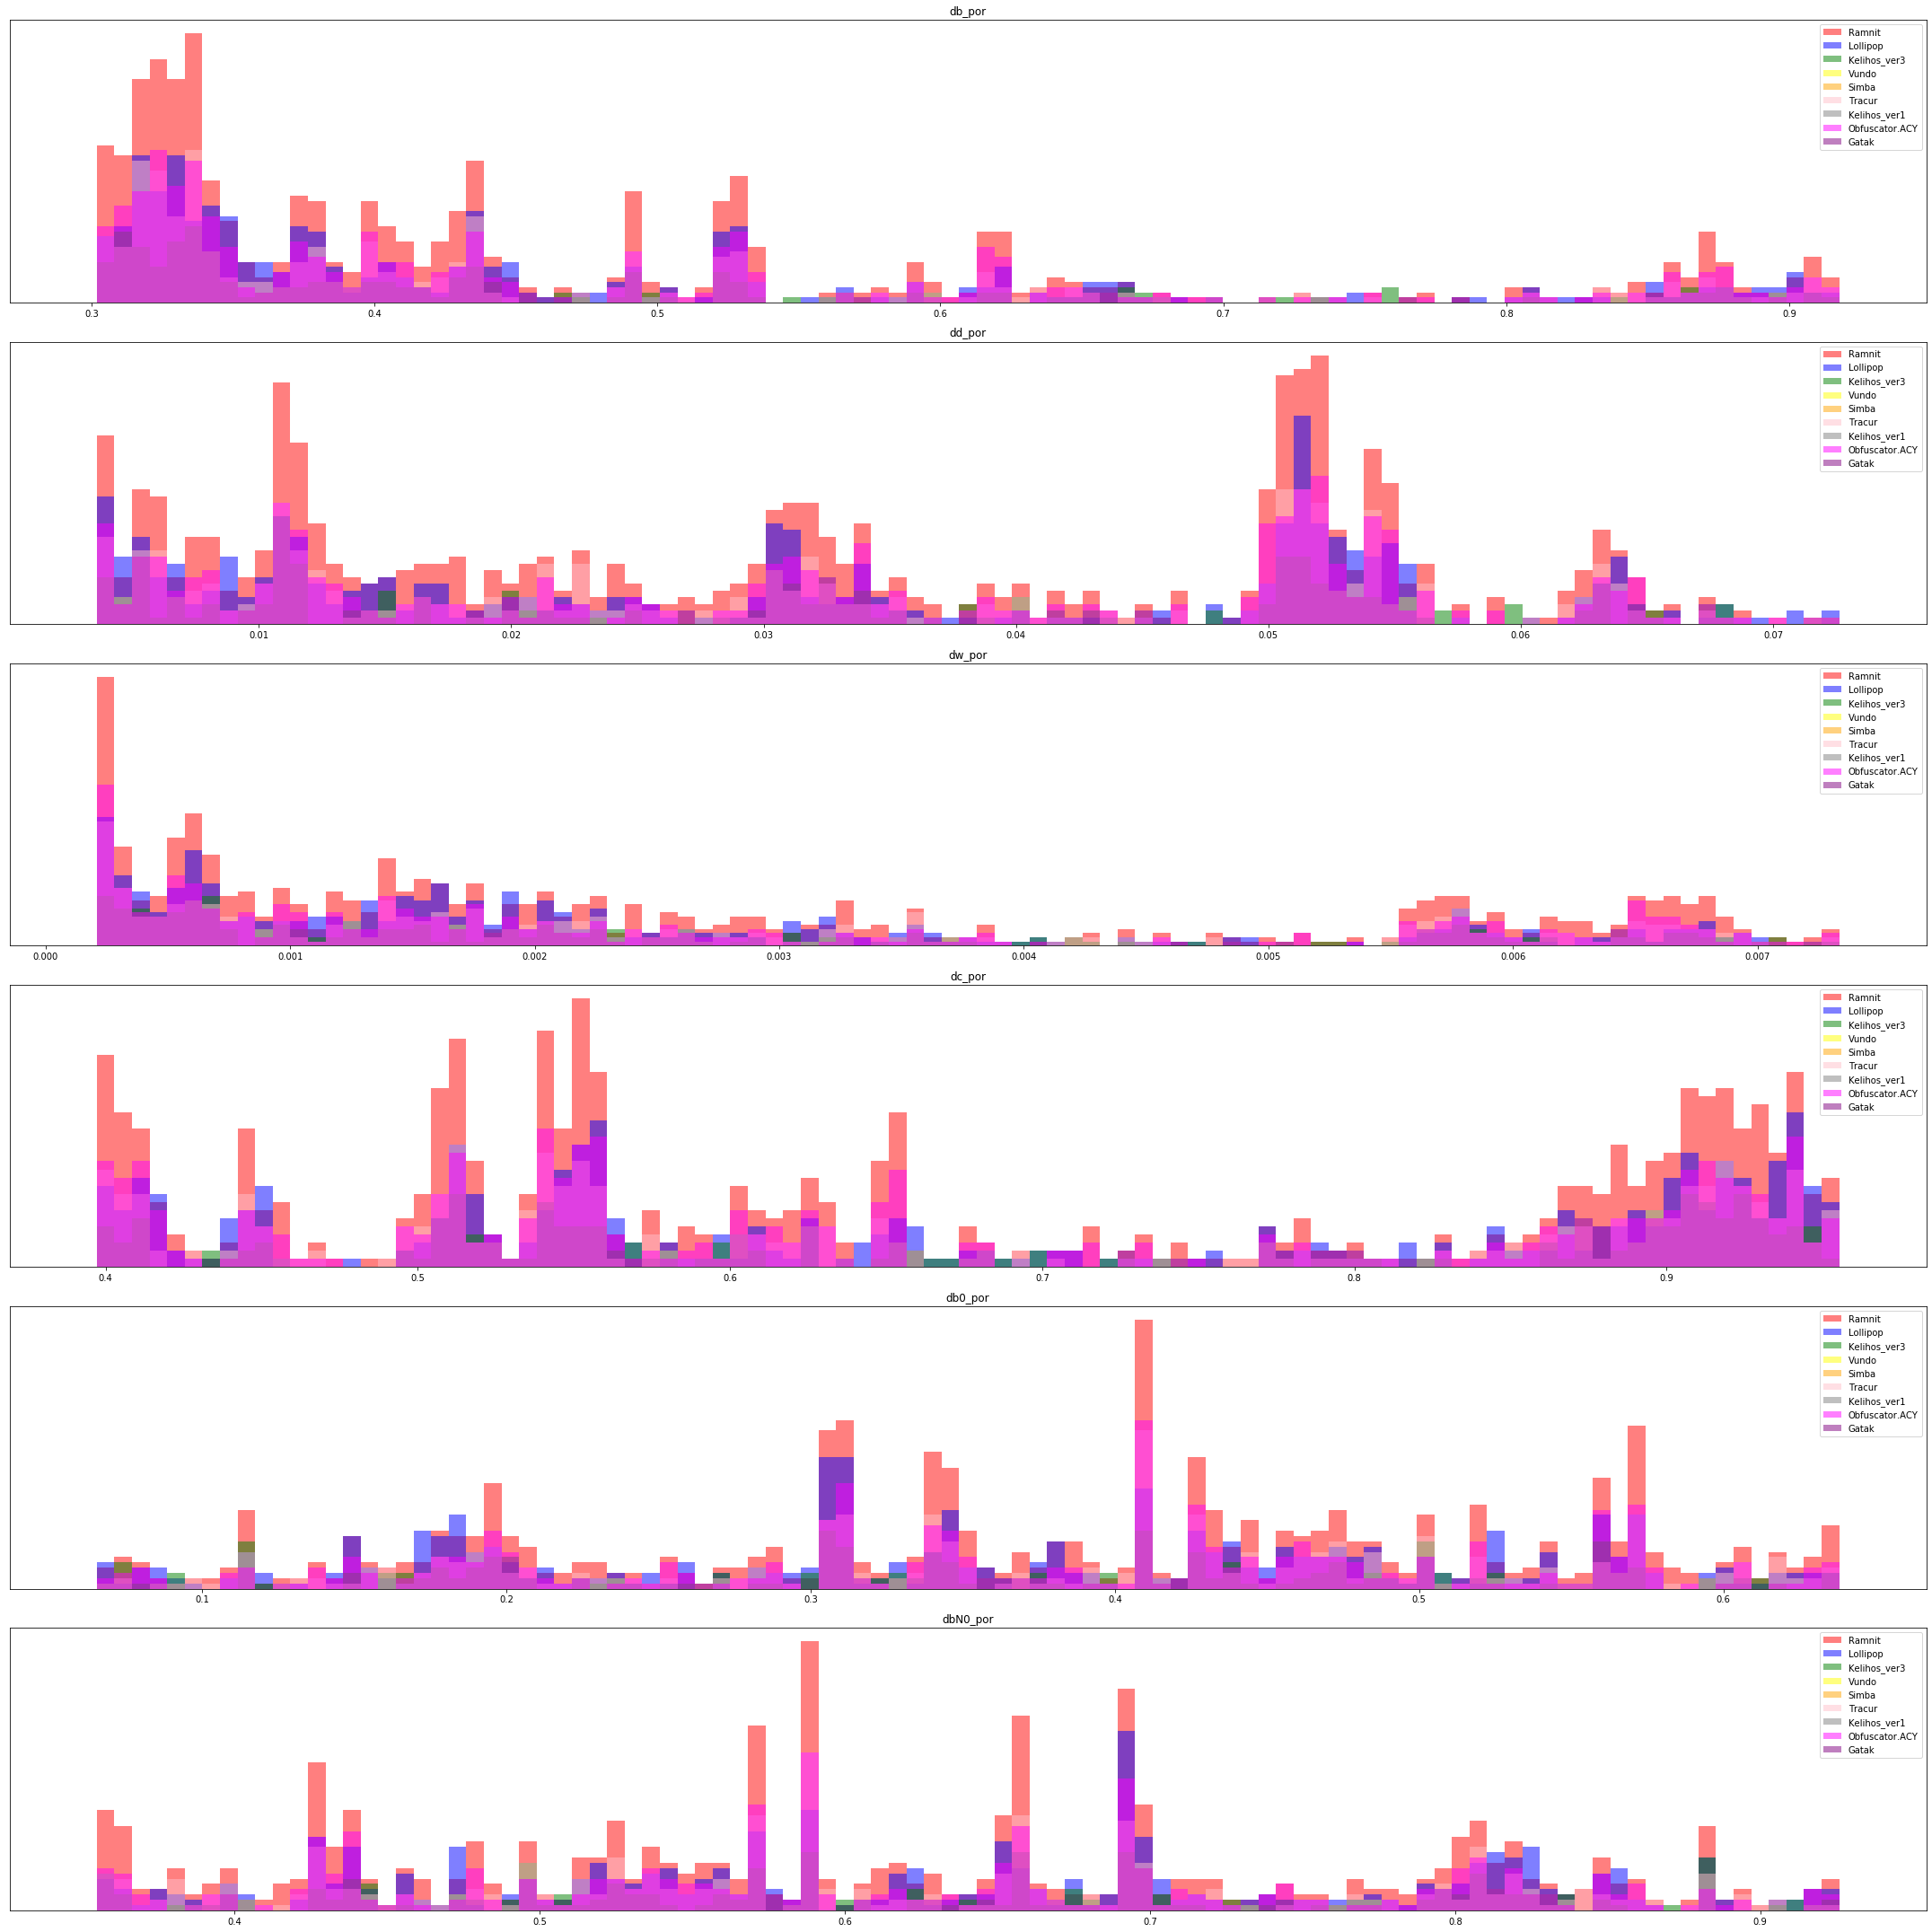

In [164]:
draw_histograms_rows_quantile( data = dd_features, 
                              classes = classes_begining_and_end_in_features,
                              features = [0,1,2,3,4,5],
                              sections = 100, 
                              no_rows = 6, no_cols = 1, 
                              fig_x = 30, fig_y = 30,
                              i_want_whole_range = [False]*6)

#### API
_API_

In [ ]:
# todo

#### ključne riječi
_KEYW_

In [ ]:
# todo

<br>
<br>

## Odabir najznačajnijih značajki
_Feature fusion_

_KOMENTAR_
[//]: # "Možemo npr ovako https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e"

In [ ]:
# ovo nije kod za nase podatke! 
# niti mozda onaj koji cemo mi koristiti, po danasnjim vjezbama, trebalo bi vjerojatno raditi onu uninvarijantnu metodu
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html

# FEATURE IMPORTANCE
# Feature importance is an inbuilt class that comes with Tree Based Classifiers, 
# we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

data = pd.read_csv("D://Blogs//train.csv") #path to data
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()